#CNN

Este trabalho foi realizado no âmbito da unidade curricular de **Análise Computacional Avançada**.
 O estudo foi desenvolvido por

**José Cunha (2021223719)**,
**Marta Antunes (2021216180)**.


## Índice

1. [Análise Sem Balanceamento](#1-análise-sem-balanceamento)  
   1.1. Análise do Dataset  
   1.2. Implementação da Rede CNN  
   1.3. Grid Search para Hiperparâmetros  
   1.4. Teste com Diferentes Funções de Perda e Otimizadores  
   1.5. Avaliação nos Dados de Teste  

2. [Análise com Balanceamento](#2-análise-com-balanceamento)  
   2.1. Estratégia de Balanceamento e Geração de Dados  
   2.2. Implementação da Rede CNN  
   2.3. Grid Search  
   2.4. Teste com Funções de Perda e Otimizadores  
   2.5. Avaliação nos Dados de Teste

3. [Melhorias na CNN (Enhanced CNN)](#3-melhorias-na-cnn-enhanced-cnn)  
   3.1. Teste com Diferentes Níveis de Balanceamento (500, 1500, 2000 amostras por classe)  
   3.2. Aprofundamento da Rede: Mais Neurónios nas Camadas Densas  

---



In [1]:
#Configuração do ambiente para trabalhar com o MedMNIST
!pip install medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [7]:
#Escolha do melhor dispositivo para executar as operações do pytorch
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


data_flag = 'dermamnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# 1.1 Análise do Dataset DermaMNIST

Este código realiza uma análise da distribuição de classes no dataset DermaMNIST do MedMNIST.

## O que o código faz:

1. **Importação de bibliotecas**
   - Utiliza `medmnist` para acessar os dados médicos
   - Usa `collections` e `matplotlib` para análise e visualização

2. **Configuração do dataset**
   - Define o dataset como 'dermamnist'
   - Obtém metadados e informações das classes

3. **Carregamento dos dados**
   - Baixa e carrega os conjuntos de:
     - Treino (`train`)
     - Validação (`val`)
     - Teste (`test`)

4. **Análise de distribuição**
   - Conta o número de amostras por classe em cada conjunto
   - Exibe os resultados no console

5. **Visualização**
   - Cria um gráfico de barras comparando a distribuição:
     - Barras azuis: dados de treino
     - Barras laranjas: dados de validação
     - Barras verdes: dados de teste
   - Rotula os eixos com os nomes das classes dermatológicas

## Objetivo:
Mostrar como as imagens estão distribuídas entre as diferentes classes de condições dermatológicas nos conjuntos de treino, validação e teste.

📊 Distribuição de Classes no Dataset:
Treino: Counter({5: 4693, 4: 779, 2: 769, 1: 359, 0: 228, 6: 99, 3: 80})
Validação: Counter({5: 671, 4: 111, 2: 110, 1: 52, 0: 33, 6: 14, 3: 12})
Teste: Counter({5: 1341, 4: 223, 2: 220, 1: 103, 0: 66, 6: 29, 3: 23})


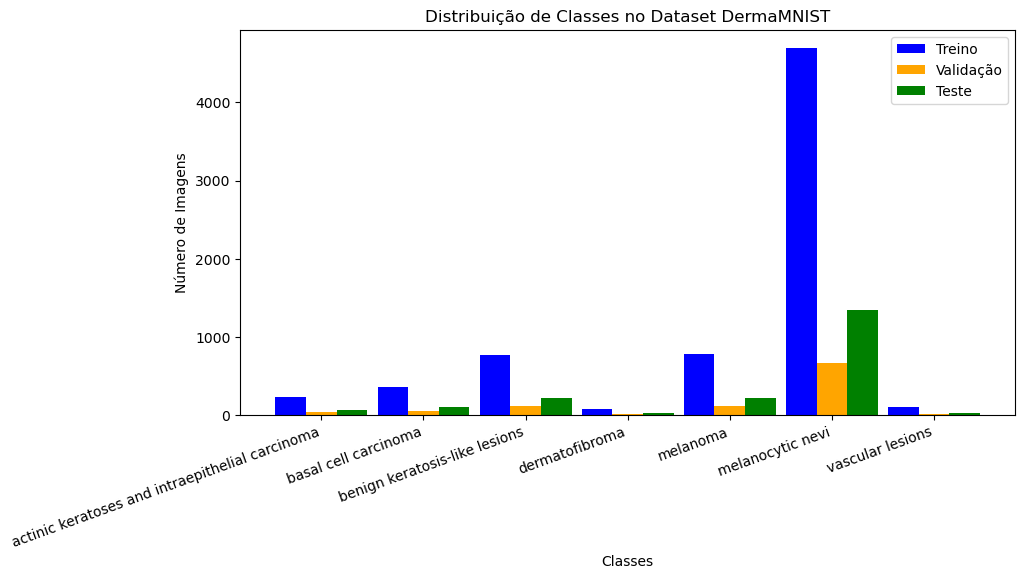

In [3]:
import medmnist
from medmnist import INFO
import collections
import matplotlib.pyplot as plt

# Definir o dataset DermaMNIST
data_flag = 'dermamnist'
download = True

# Obter informações sobre o dataset
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
class_labels = info['label']  # Nome das classes

# Carregar os datasets completos
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

# Função para contar a distribuição de classes
def contar_classes(dataset):
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    return collections.Counter(labels)

# Obter a contagem das classes
train_counts = contar_classes(train_dataset)
val_counts = contar_classes(val_dataset)
test_counts = contar_classes(test_dataset)

# Mostrar a distribuição das classes
print("📊 Distribuição de Classes no Dataset:")
print(f"Treino: {train_counts}")
print(f"Validação: {val_counts}")
print(f"Teste: {test_counts}")

# Converter para listas para plotagem
labels = list(class_labels.values())
train_values = [train_counts[i] for i in range(len(labels))]
val_values = [val_counts[i] for i in range(len(labels))]
test_values = [test_counts[i] for i in range(len(labels))]

# Criar gráfico de barras
fig, ax = plt.subplots(figsize=(10,5))
width = 0.3  # Largura das barras

# Plotar distribuição das classes
ax.bar([x - width for x in range(len(labels))], train_values, width=width, label='Treino', color='blue')
ax.bar(range(len(labels)), val_values, width=width, label='Validação', color='orange')
ax.bar([x + width for x in range(len(labels))], test_values, width=width, label='Teste', color='green')

# Ajustar detalhes do gráfico
ax.set_xlabel("Classes")
ax.set_ylabel("Número de Imagens")
ax.set_title("Distribuição de Classes no Dataset DermaMNIST")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.legend()

# Mostrar gráfico
plt.show()

# 1.2 CNN teste para descoberta do numero ideal de epochs

## Visão Geral
Este código implementa um pipeline completo para classificação de imagens dermatológicas usando o dataset DermaMNIST, incluindo:
- Análise exploratória de dados
- Pré-processamento
- Modelagem com CNN
- Treinamento e avaliação
- Visualização de resultados

## Fluxo do Pipeline

### 1. Configuração Inicial
- **Reprodutibilidade**: Define seed aleatória (42)
- **Dispositivo**: Detecta automaticamente GPU/CPU
- **Parâmetros**: Batch size (64), epochs (120)

### 2. Pré-processamento de Dados
- **Transformações**:
  - Conversão para tensor
  - Normalização (mean=0.5, std=0.5)
- **DataLoaders**:
  - Conjuntos de treino/validação/teste
  - Shuffle apenas no treino

### 3. Arquitetura do Modelo (CNN)
     3 blocos convolucionais com:
     - Conv2d + BatchNorm + ReLU + MaxPool
     - Camadas fully connected finais com dropout

📊 Distribuição de Classes no Dataset:
Treino: Counter({5: 4693, 4: 779, 2: 769, 1: 359, 0: 228, 6: 99, 3: 80})
Validação: Counter({5: 671, 4: 111, 2: 110, 1: 52, 0: 33, 6: 14, 3: 12})
Teste: Counter({5: 1341, 4: 223, 2: 220, 1: 103, 0: 66, 6: 29, 3: 23})
Using device: mps

Epoch 1/120


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training: 100%|██████████| 110/110 [00:02<00:00, 53.19it/s]


Saved new best model based on training accuracy!
Train Loss: 0.9205 | Train Acc: 0.6755

Epoch 2/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.62it/s]


Saved new best model based on training accuracy!
Train Loss: 0.8079 | Train Acc: 0.7037

Epoch 3/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.36it/s]


Saved new best model based on training accuracy!
Train Loss: 0.7614 | Train Acc: 0.7200

Epoch 4/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.87it/s]


Saved new best model based on training accuracy!
Train Loss: 0.7346 | Train Acc: 0.7271

Epoch 5/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.77it/s]


Saved new best model based on training accuracy!
Train Loss: 0.6980 | Train Acc: 0.7428

Epoch 6/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.42it/s]


Saved new best model based on training accuracy!
Train Loss: 0.6749 | Train Acc: 0.7498

Epoch 7/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.96it/s]


Saved new best model based on training accuracy!
Train Loss: 0.6608 | Train Acc: 0.7577

Epoch 8/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.50it/s]


Saved new best model based on training accuracy!
Train Loss: 0.6470 | Train Acc: 0.7600

Epoch 9/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.95it/s]


Saved new best model based on training accuracy!
Train Loss: 0.6219 | Train Acc: 0.7675

Epoch 10/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.78it/s]


Saved new best model based on training accuracy!
Train Loss: 0.6154 | Train Acc: 0.7722

Epoch 11/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.58it/s]


Saved new best model based on training accuracy!
Train Loss: 0.5941 | Train Acc: 0.7747

Epoch 12/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.10it/s]


Saved new best model based on training accuracy!
Train Loss: 0.5638 | Train Acc: 0.7885

Epoch 13/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.52it/s]


Saved new best model based on training accuracy!
Train Loss: 0.5435 | Train Acc: 0.7952

Epoch 14/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.21it/s]


Saved new best model based on training accuracy!
Train Loss: 0.5264 | Train Acc: 0.8048

Epoch 15/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.80it/s]


Saved new best model based on training accuracy!
Train Loss: 0.5020 | Train Acc: 0.8118

Epoch 16/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.46it/s]


Saved new best model based on training accuracy!
Train Loss: 0.4732 | Train Acc: 0.8215

Epoch 17/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.18it/s]


Saved new best model based on training accuracy!
Train Loss: 0.4532 | Train Acc: 0.8330

Epoch 18/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.72it/s]


Saved new best model based on training accuracy!
Train Loss: 0.4332 | Train Acc: 0.8387

Epoch 19/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.44it/s]


Saved new best model based on training accuracy!
Train Loss: 0.3933 | Train Acc: 0.8514

Epoch 20/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.70it/s]


Saved new best model based on training accuracy!
Train Loss: 0.3612 | Train Acc: 0.8656

Epoch 21/120


Training: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s]


Saved new best model based on training accuracy!
Train Loss: 0.3409 | Train Acc: 0.8733

Epoch 22/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.73it/s]


Saved new best model based on training accuracy!
Train Loss: 0.3122 | Train Acc: 0.8841

Epoch 23/120


Training: 100%|██████████| 110/110 [00:01<00:00, 55.67it/s]


Saved new best model based on training accuracy!
Train Loss: 0.2882 | Train Acc: 0.8944

Epoch 24/120


Training: 100%|██████████| 110/110 [00:01<00:00, 62.06it/s]


Saved new best model based on training accuracy!
Train Loss: 0.2537 | Train Acc: 0.9045

Epoch 25/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.12it/s]


Saved new best model based on training accuracy!
Train Loss: 0.2178 | Train Acc: 0.9199

Epoch 26/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.92it/s]


Saved new best model based on training accuracy!
Train Loss: 0.2061 | Train Acc: 0.9265

Epoch 27/120


Training: 100%|██████████| 110/110 [00:01<00:00, 62.97it/s]


Saved new best model based on training accuracy!
Train Loss: 0.1890 | Train Acc: 0.9332

Epoch 28/120


Training: 100%|██████████| 110/110 [00:01<00:00, 63.05it/s]


Saved new best model based on training accuracy!
Train Loss: 0.1647 | Train Acc: 0.9423

Epoch 29/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.11it/s]


Saved new best model based on training accuracy!
Train Loss: 0.1579 | Train Acc: 0.9433

Epoch 30/120


Training: 100%|██████████| 110/110 [00:01<00:00, 63.40it/s]


Saved new best model based on training accuracy!
Train Loss: 0.1279 | Train Acc: 0.9556

Epoch 31/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.99it/s]


Train Loss: 0.1397 | Train Acc: 0.9492

Epoch 32/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.39it/s]


Saved new best model based on training accuracy!
Train Loss: 0.1142 | Train Acc: 0.9599

Epoch 33/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.70it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0973 | Train Acc: 0.9677

Epoch 34/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.60it/s]


Train Loss: 0.0996 | Train Acc: 0.9663

Epoch 35/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.53it/s]


Train Loss: 0.1008 | Train Acc: 0.9639

Epoch 36/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.95it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0865 | Train Acc: 0.9682

Epoch 37/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.03it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0828 | Train Acc: 0.9719

Epoch 38/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.37it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0715 | Train Acc: 0.9740

Epoch 39/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.15it/s]


Train Loss: 0.0833 | Train Acc: 0.9727

Epoch 40/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.89it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0729 | Train Acc: 0.9747

Epoch 41/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.64it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0620 | Train Acc: 0.9814

Epoch 42/120


Training: 100%|██████████| 110/110 [00:01<00:00, 62.69it/s]


Train Loss: 0.0568 | Train Acc: 0.9802

Epoch 43/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.71it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0545 | Train Acc: 0.9837

Epoch 44/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.91it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0513 | Train Acc: 0.9840

Epoch 45/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.82it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0407 | Train Acc: 0.9866

Epoch 46/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.80it/s]


Train Loss: 0.0718 | Train Acc: 0.9740

Epoch 47/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.51it/s]


Train Loss: 0.0469 | Train Acc: 0.9846

Epoch 48/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.00it/s]


Train Loss: 0.0533 | Train Acc: 0.9810

Epoch 49/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.93it/s]


Train Loss: 0.0442 | Train Acc: 0.9862

Epoch 50/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.38it/s]


Train Loss: 0.0605 | Train Acc: 0.9796

Epoch 51/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.75it/s]


Train Loss: 0.0503 | Train Acc: 0.9829

Epoch 52/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.01it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0305 | Train Acc: 0.9906

Epoch 53/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.76it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0162 | Train Acc: 0.9963

Epoch 54/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.16it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0143 | Train Acc: 0.9966

Epoch 55/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.08it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0115 | Train Acc: 0.9973

Epoch 56/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.89it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0100 | Train Acc: 0.9983

Epoch 57/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.61it/s]


Train Loss: 0.0090 | Train Acc: 0.9979

Epoch 58/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.13it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0077 | Train Acc: 0.9986

Epoch 59/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.36it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0073 | Train Acc: 0.9990

Epoch 60/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.63it/s]


Train Loss: 0.0075 | Train Acc: 0.9984

Epoch 61/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.99it/s]


Train Loss: 0.0072 | Train Acc: 0.9989

Epoch 62/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.18it/s]


Train Loss: 0.0067 | Train Acc: 0.9987

Epoch 63/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.41it/s]


Train Loss: 0.0072 | Train Acc: 0.9987

Epoch 64/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.51it/s]


Train Loss: 0.0071 | Train Acc: 0.9986

Epoch 65/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.08it/s]


Train Loss: 0.0061 | Train Acc: 0.9989

Epoch 66/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.47it/s]


Train Loss: 0.0051 | Train Acc: 0.9989

Epoch 67/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.71it/s]


Train Loss: 0.0052 | Train Acc: 0.9990

Epoch 68/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.86it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0042 | Train Acc: 0.9996

Epoch 69/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.14it/s]


Train Loss: 0.0057 | Train Acc: 0.9987

Epoch 70/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.75it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0032 | Train Acc: 0.9997

Epoch 71/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.76it/s]


Train Loss: 0.0044 | Train Acc: 0.9994

Epoch 72/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.08it/s]


Train Loss: 0.0050 | Train Acc: 0.9987

Epoch 73/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.63it/s]


Train Loss: 0.0037 | Train Acc: 0.9996

Epoch 74/120


Training: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s]


Train Loss: 0.0047 | Train Acc: 0.9991

Epoch 75/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.79it/s]


Train Loss: 0.0057 | Train Acc: 0.9983

Epoch 76/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.60it/s]


Train Loss: 0.0042 | Train Acc: 0.9996

Epoch 77/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.19it/s]


Train Loss: 0.0041 | Train Acc: 0.9994

Epoch 78/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.21it/s]


Train Loss: 0.0038 | Train Acc: 0.9994

Epoch 79/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.11it/s]


Train Loss: 0.0039 | Train Acc: 0.9993

Epoch 80/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.35it/s]


Train Loss: 0.0036 | Train Acc: 0.9997

Epoch 81/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.11it/s]


Train Loss: 0.0035 | Train Acc: 0.9996

Epoch 82/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.88it/s]


Train Loss: 0.0038 | Train Acc: 0.9991

Epoch 83/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.10it/s]


Train Loss: 0.0035 | Train Acc: 0.9996

Epoch 84/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.41it/s]


Train Loss: 0.0036 | Train Acc: 0.9994

Epoch 85/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.29it/s]


Train Loss: 0.0033 | Train Acc: 0.9996

Epoch 86/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.69it/s]


Train Loss: 0.0044 | Train Acc: 0.9989

Epoch 87/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.49it/s]


Train Loss: 0.0039 | Train Acc: 0.9994

Epoch 88/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.26it/s]


Train Loss: 0.0044 | Train Acc: 0.9991

Epoch 89/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.14it/s]


Train Loss: 0.0033 | Train Acc: 0.9996

Epoch 90/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.98it/s]


Train Loss: 0.0050 | Train Acc: 0.9984

Epoch 91/120


Training: 100%|██████████| 110/110 [00:01<00:00, 62.04it/s]


Train Loss: 0.0044 | Train Acc: 0.9987

Epoch 92/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.65it/s]


Train Loss: 0.0037 | Train Acc: 0.9991

Epoch 93/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.33it/s]


Train Loss: 0.0034 | Train Acc: 0.9994

Epoch 94/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.95it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0028 | Train Acc: 0.9999

Epoch 95/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.53it/s]


Train Loss: 0.0037 | Train Acc: 0.9990

Epoch 96/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.77it/s]


Train Loss: 0.0039 | Train Acc: 0.9994

Epoch 97/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.90it/s]


Train Loss: 0.0036 | Train Acc: 0.9993

Epoch 98/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.75it/s]


Train Loss: 0.0029 | Train Acc: 0.9997

Epoch 99/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.31it/s]


Train Loss: 0.0032 | Train Acc: 0.9994

Epoch 100/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.25it/s]


Train Loss: 0.0036 | Train Acc: 0.9994

Epoch 101/120


Training: 100%|██████████| 110/110 [00:01<00:00, 57.32it/s]


Train Loss: 0.0039 | Train Acc: 0.9990

Epoch 102/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.06it/s]


Train Loss: 0.0037 | Train Acc: 0.9994

Epoch 103/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.26it/s]


Train Loss: 0.0031 | Train Acc: 0.9997

Epoch 104/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.06it/s]


Train Loss: 0.0029 | Train Acc: 0.9996

Epoch 105/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.80it/s]


Saved new best model based on training accuracy!
Train Loss: 0.0031 | Train Acc: 1.0000

Epoch 106/120


Training: 100%|██████████| 110/110 [00:01<00:00, 58.19it/s]


Train Loss: 0.0029 | Train Acc: 0.9997

Epoch 107/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.49it/s]


Train Loss: 0.0040 | Train Acc: 0.9990

Epoch 108/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.85it/s]


Train Loss: 0.0039 | Train Acc: 0.9990

Epoch 109/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.00it/s]


Train Loss: 0.0033 | Train Acc: 0.9994

Epoch 110/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.29it/s]


Train Loss: 0.0035 | Train Acc: 0.9994

Epoch 111/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.31it/s]


Train Loss: 0.0034 | Train Acc: 0.9991

Epoch 112/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.91it/s]


Train Loss: 0.0028 | Train Acc: 0.9997

Epoch 113/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.14it/s]


Train Loss: 0.0033 | Train Acc: 0.9994

Epoch 114/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.71it/s]


Train Loss: 0.0030 | Train Acc: 0.9993

Epoch 115/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.25it/s]


Train Loss: 0.0034 | Train Acc: 0.9991

Epoch 116/120


Training: 100%|██████████| 110/110 [00:01<00:00, 62.56it/s]


Train Loss: 0.0042 | Train Acc: 0.9991

Epoch 117/120


Training: 100%|██████████| 110/110 [00:01<00:00, 56.21it/s]


Train Loss: 0.0037 | Train Acc: 0.9991

Epoch 118/120


Training: 100%|██████████| 110/110 [00:01<00:00, 60.05it/s]


Train Loss: 0.0031 | Train Acc: 0.9999

Epoch 119/120


Training: 100%|██████████| 110/110 [00:01<00:00, 61.98it/s]


Train Loss: 0.0037 | Train Acc: 0.9996

Epoch 120/120


Training: 100%|██████████| 110/110 [00:01<00:00, 59.70it/s]


Train Loss: 0.0043 | Train Acc: 0.9986


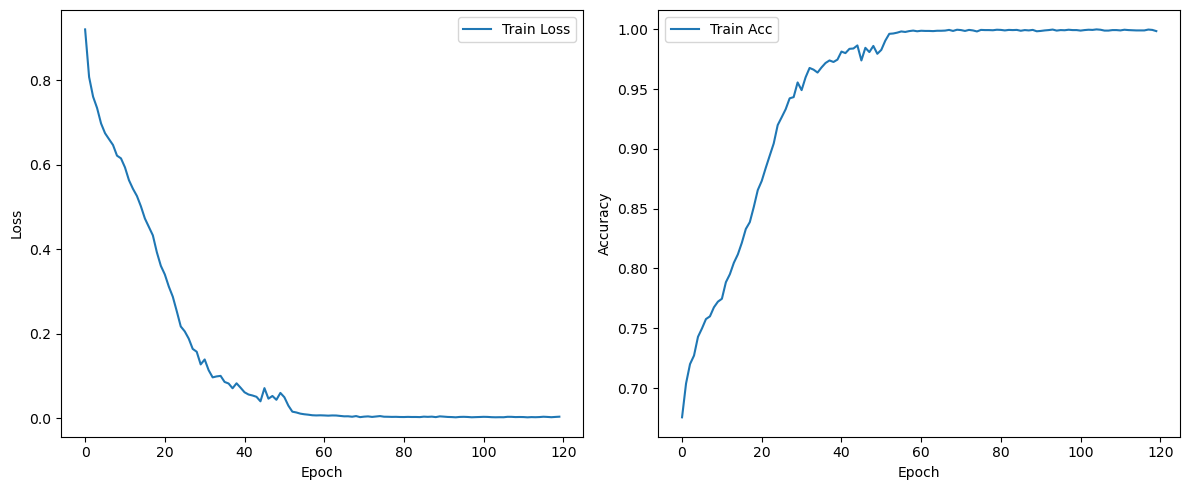


Evaluating on validation set...


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 66.33it/s]


Validation Loss: 1.9784 | Validation Acc: 0.7557

Classification Report:
               0      1       2      3       4       5      6  accuracy  macro avg  weighted avg
precision   0.42   0.50    0.54   1.00    0.43    0.87   0.90      0.76       0.67          0.76
recall      0.42   0.58    0.45   0.17    0.45    0.90   0.64      0.76       0.52          0.76
f1-score    0.42   0.54    0.49   0.29    0.44    0.89   0.75      0.76       0.54          0.75
support    33.00  52.00  110.00  12.00  111.00  671.00  14.00      0.76    1003.00       1003.00


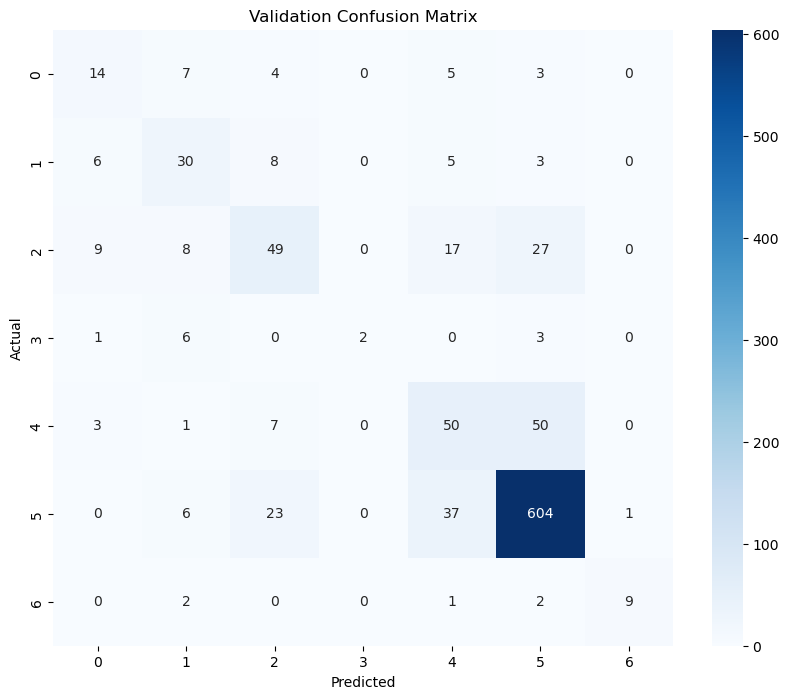

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

# Set random seed for reproducibility
torch.manual_seed(42)

# Dataset and Data Loading
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 64

# Show class distribution
print("📊 Distribuição de Classes no Dataset:")
print(f"Treino: {train_counts}")
print(f"Validação: {val_counts}")
print(f"Teste: {test_counts}")

# Convert to lists for plotting
train_values = [train_counts[i] for i in range(n_classes)]
val_values = [val_counts[i] for i in range(n_classes)]
test_values = [test_counts[i] for i in range(n_classes)]

# Create bar plot

# Minimal transforms - just convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transforms to datasets
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


print(f"Using device: {device}")

# CNN Model
class DermaCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(DermaCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = DermaCNN(n_channels, n_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device).squeeze()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Enhanced evaluation function with more metrics
def evaluate(model, loader, criterion, device, class_labels=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    
    # Calculate additional metrics
    report = classification_report(all_labels, all_preds, target_names=class_labels, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, report, cm

# Training loop
num_epochs = 120
best_train_acc = 0.0
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    scheduler.step(train_loss)
    
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        torch.save(model.state_dict(), "train_only_baseline.pth")
        print("Saved new best model based on training accuracy!")
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('train_only_training_curves.png')
plt.show()

# Evaluate on validation with additional metrics
print("\nEvaluating on validation set...")
model.load_state_dict(torch.load("train_only_baseline.pth"))
val_loss, val_acc, val_report, val_cm = evaluate(model, val_loader, criterion, device, class_labels)

print(f"\nValidation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f}")

# Print classification report - use the report we got from evaluate()
print("\nClassification Report:")
print(pd.DataFrame(val_report).round(2).to_string())  # Nicer formatted output

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('validation_confusion_matrix.png')
plt.show()

# 1.3 Grid Search

## Visão Geral do Pipeline
Este código implementa um sistema completo de Grid Search para otimizar hiperparâmetros de uma CNN no dataset DermaMNIST, incluindo:
- Arquitetura flexível da CNN
- Busca exaustiva de hiperparâmetros
- Métricas avançadas de avaliação
- Armazenamento de resultados
- Visualização de desempenho

## Componentes Principais

### 1. Configuração Inicial
- **Dispositivo**: Detecta automaticamente MPS (Apple Silicon), CUDA (NVIDIA) ou CPU
- **Reprodutibilidade**: Seed fixa para consistência

### 2. Arquitetura Flexível da CNN
    - Camadas convolucionais dinâmicas:
    - Número de camadas configurável
    - Filtros crescem exponencialmente
    - Cálculo automático do tamanho da saída
    -Camadas fully connected com dropout


### 3. Grade de Hiperparâmetros
```python
param_grid = {
    'conv_layers': [2, 3, 4],        # Profundidade da rede
    'initial_filters': [32, 64, 128], # Filtros na primeira camada
    'lr': [0.005, 0.001, 0.0005],    # Taxas de aprendizado
    'batch_size': [64, 128, 256],     # Tamanhos de batch
    'epochs': [100]                  # Épocas de treino
}
```

### 4. Fluxo de Treinamento
1. **Preparação de Dados**:
   - DataLoaders com batch size variável
   - Transformações básicas (ToTensor + Normalize)

2. **Rotina de Treino**:
   - Loop por épocas com tqdm para progresso
   - Cálculo de loss e acurácia
   - Otimização com Adam

3. **Avaliação**:
   - Loss e acurácia
   - **F1-score ponderado** (nova métrica principal)
   - Função de avaliação completa com:
     - Classification report
     - Matriz de confusão visual

### 5. Sistema de Grid Search
- **Armazenamento**:
  - Salva cada modelo treinado (.pth)
  - Salva resultados em JSON
  - Cria estrutura de diretórios organizada

- **Análise de Resultados**:
  - Seleciona melhor modelo baseado no F1-score
  - Gera relatórios completos do melhor modelo
  - Plota curvas de treino (loss e acurácia)

### 6. Visualizações
1. **Curvas de Treino**:
   - Loss vs Época
   - Acurácia vs Época

2. **Matriz de Confusão**:
   - Anotada com contagens
   - Mapeamento para labels reais
   - Esquema de cores azul

## Melhorias Implementadas

1. **Seleção por F1-score**:
   - Substitui acurácia como métrica principal
   - Mais robusta para classes desbalanceadas

2. **Arquitetura Dinâmica**:
   - Adapta automaticamente ao número de camadas
   - Calcula tamanho da saída das convoluções

3. **Otimizações de Performance**:
   - Armazenamento eficiente de resultados
   - Barra de progresso para combinações
   - Tempo total de execução monitorado

4. **Análise Detalhada**:
   - Classification report completo
   - Suporte a zero_division
   - Visualização profissional da matriz

## Saídas Geradas
- Modelos treinados (`.pth`)
- Resultados em JSON
- Gráficos de treino (`.png`)
- Matriz de confusão (`.png`)
- Logs de progresso no console


Using device: mps
Iniciando Grid Search com 81 combinacoes de parametros

Combinacao 1/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 0}


Finalizado - Val_acc: 0.7428 - Val_f1: 0.7368

Combinacao 2/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 1}


Finalizado - Val_acc: 0.7717 - Val_f1: 0.7617

Combinacao 3/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 2}


Finalizado - Val_acc: 0.7507 - Val_f1: 0.7470

Combinacao 4/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 3}


Finalizado - Val_acc: 0.7338 - Val_f1: 0.7273

Combinacao 5/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 4}


Finalizado - Val_acc: 0.7368 - Val_f1: 0.7315

Combinacao 6/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 5}


Finalizado - Val_acc: 0.7458 - Val_f1: 0.7361

Combinacao 7/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 6}


Finalizado - Val_acc: 0.7557 - Val_f1: 0.7422

Combinacao 8/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 7}


Finalizado - Val_acc: 0.7527 - Val_f1: 0.7401

Combinacao 9/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 8}


Finalizado - Val_acc: 0.7507 - Val_f1: 0.7414

Combinacao 10/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 9}


Finalizado - Val_acc: 0.7587 - Val_f1: 0.7496

Combinacao 11/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 10}


Finalizado - Val_acc: 0.7238 - Val_f1: 0.7273

Combinacao 12/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 11}


Finalizado - Val_acc: 0.7527 - Val_f1: 0.7475

Combinacao 13/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 12}


Finalizado - Val_acc: 0.7348 - Val_f1: 0.7276

Combinacao 14/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 13}


Finalizado - Val_acc: 0.7438 - Val_f1: 0.7337

Combinacao 15/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 14}


Finalizado - Val_acc: 0.7527 - Val_f1: 0.7511

Combinacao 16/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 15}


Finalizado - Val_acc: 0.7478 - Val_f1: 0.7364

Combinacao 17/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 16}


Finalizado - Val_acc: 0.7488 - Val_f1: 0.7379

Combinacao 18/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 17}


Finalizado - Val_acc: 0.7647 - Val_f1: 0.7489

Combinacao 19/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 18}


Finalizado - Val_acc: 0.7398 - Val_f1: 0.7304

Combinacao 20/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 19}


Finalizado - Val_acc: 0.7248 - Val_f1: 0.7292

Combinacao 21/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 20}


Finalizado - Val_acc: 0.7637 - Val_f1: 0.7583

Combinacao 22/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 21}


Finalizado - Val_acc: 0.7338 - Val_f1: 0.7299

Combinacao 23/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 22}


Finalizado - Val_acc: 0.7438 - Val_f1: 0.7402

Combinacao 24/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 23}


Finalizado - Val_acc: 0.7567 - Val_f1: 0.7533

Combinacao 25/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 24}


Finalizado - Val_acc: 0.7498 - Val_f1: 0.7319

Combinacao 26/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 25}


Finalizado - Val_acc: 0.7657 - Val_f1: 0.7608

Combinacao 27/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 26}


Finalizado - Val_acc: 0.7428 - Val_f1: 0.7465

Combinacao 28/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 27}


Finalizado - Val_acc: 0.7498 - Val_f1: 0.7372

Combinacao 29/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 28}


Finalizado - Val_acc: 0.7587 - Val_f1: 0.7522

Combinacao 30/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 29}


Finalizado - Val_acc: 0.7687 - Val_f1: 0.7597

Combinacao 31/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 30}


Finalizado - Val_acc: 0.7727 - Val_f1: 0.7594

Combinacao 32/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 31}


Finalizado - Val_acc: 0.7697 - Val_f1: 0.7588

Combinacao 33/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 32}


Finalizado - Val_acc: 0.7677 - Val_f1: 0.7607

Combinacao 34/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 33}


Finalizado - Val_acc: 0.7478 - Val_f1: 0.7414

Combinacao 35/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 34}


Finalizado - Val_acc: 0.7667 - Val_f1: 0.7591

Combinacao 36/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 35}


Finalizado - Val_acc: 0.7537 - Val_f1: 0.7385

Combinacao 37/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 36}


Finalizado - Val_acc: 0.7318 - Val_f1: 0.7262

Combinacao 38/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 37}


Finalizado - Val_acc: 0.7478 - Val_f1: 0.7447

Combinacao 39/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 38}


Finalizado - Val_acc: 0.7308 - Val_f1: 0.7301

Combinacao 40/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 39}


Finalizado - Val_acc: 0.7507 - Val_f1: 0.7403

Combinacao 41/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 40}


Finalizado - Val_acc: 0.7527 - Val_f1: 0.7465

Combinacao 42/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 41}


Finalizado - Val_acc: 0.7657 - Val_f1: 0.7573

Combinacao 43/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 42}


Finalizado - Val_acc: 0.7089 - Val_f1: 0.7144

Combinacao 44/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 43}


Finalizado - Val_acc: 0.7537 - Val_f1: 0.7501

Combinacao 45/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 44}


Finalizado - Val_acc: 0.7507 - Val_f1: 0.7387

Combinacao 46/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 45}


Finalizado - Val_acc: 0.7368 - Val_f1: 0.7335

Combinacao 47/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 46}


Finalizado - Val_acc: 0.7408 - Val_f1: 0.7404

Combinacao 48/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 47}


Finalizado - Val_acc: 0.7607 - Val_f1: 0.7519

Combinacao 49/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 48}


Finalizado - Val_acc: 0.7587 - Val_f1: 0.7501

Combinacao 50/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 49}


Finalizado - Val_acc: 0.7697 - Val_f1: 0.7547

Combinacao 51/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 50}


Finalizado - Val_acc: 0.7627 - Val_f1: 0.7630

Combinacao 52/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 51}


Finalizado - Val_acc: 0.7458 - Val_f1: 0.7440

Combinacao 53/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 52}


Finalizado - Val_acc: 0.7667 - Val_f1: 0.7583

Combinacao 54/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 53}


Finalizado - Val_acc: 0.7527 - Val_f1: 0.7359

Combinacao 55/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 54}


Finalizado - Val_acc: 0.7368 - Val_f1: 0.7310

Combinacao 56/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 55}


Finalizado - Val_acc: 0.7468 - Val_f1: 0.7438

Combinacao 57/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 56}


Finalizado - Val_acc: 0.7657 - Val_f1: 0.7542

Combinacao 58/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 57}


Finalizado - Val_acc: 0.7488 - Val_f1: 0.7456

Combinacao 59/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 58}


Finalizado - Val_acc: 0.7507 - Val_f1: 0.7405

Combinacao 60/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 59}


Finalizado - Val_acc: 0.7657 - Val_f1: 0.7588

Combinacao 61/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 60}


Finalizado - Val_acc: 0.7408 - Val_f1: 0.7377

Combinacao 62/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 61}


Finalizado - Val_acc: 0.7687 - Val_f1: 0.7535

Combinacao 63/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 62}


Finalizado - Val_acc: 0.7537 - Val_f1: 0.7438

Combinacao 64/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 63}


Finalizado - Val_acc: 0.7517 - Val_f1: 0.7433

Combinacao 65/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 64}


Finalizado - Val_acc: 0.7278 - Val_f1: 0.7319

Combinacao 66/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 65}


Finalizado - Val_acc: 0.7597 - Val_f1: 0.7496

Combinacao 67/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 66}


Finalizado - Val_acc: 0.7418 - Val_f1: 0.7297

Combinacao 68/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 67}


Finalizado - Val_acc: 0.7567 - Val_f1: 0.7601

Combinacao 69/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 68}


Finalizado - Val_acc: 0.7637 - Val_f1: 0.7585

Combinacao 70/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 69}


Finalizado - Val_acc: 0.7228 - Val_f1: 0.7100

Combinacao 71/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 70}


Finalizado - Val_acc: 0.7547 - Val_f1: 0.7504

Combinacao 72/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 71}


Finalizado - Val_acc: 0.7757 - Val_f1: 0.7677

Combinacao 73/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 72}


Finalizado - Val_acc: 0.7438 - Val_f1: 0.7409

Combinacao 74/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 73}


Finalizado - Val_acc: 0.7039 - Val_f1: 0.7101

Combinacao 75/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 74}


Finalizado - Val_acc: 0.7218 - Val_f1: 0.7237

Combinacao 76/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 75}


Finalizado - Val_acc: 0.7248 - Val_f1: 0.7172

Combinacao 77/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 76}


Finalizado - Val_acc: 0.7478 - Val_f1: 0.7440

Combinacao 78/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 77}


Finalizado - Val_acc: 0.7717 - Val_f1: 0.7686

Combinacao 79/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 78}


Finalizado - Val_acc: 0.7468 - Val_f1: 0.7370

Combinacao 80/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 79}


Finalizado - Val_acc: 0.7637 - Val_f1: 0.7611

Combinacao 81/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 80}


Finalizado - Val_acc: 0.7537 - Val_f1: 0.7509

Melhor combinacao de parametros (baseada no F1-score):
{
    "batch_size": 256,
    "conv_layers": 4,
    "epochs": 100,
    "initial_filters": 64,
    "lr": 0.0005,
    "id": 77
}
Melhor val_acc: 0.7717
Melhor val_f1: 0.7686
Tempo total: 436.86 minutos


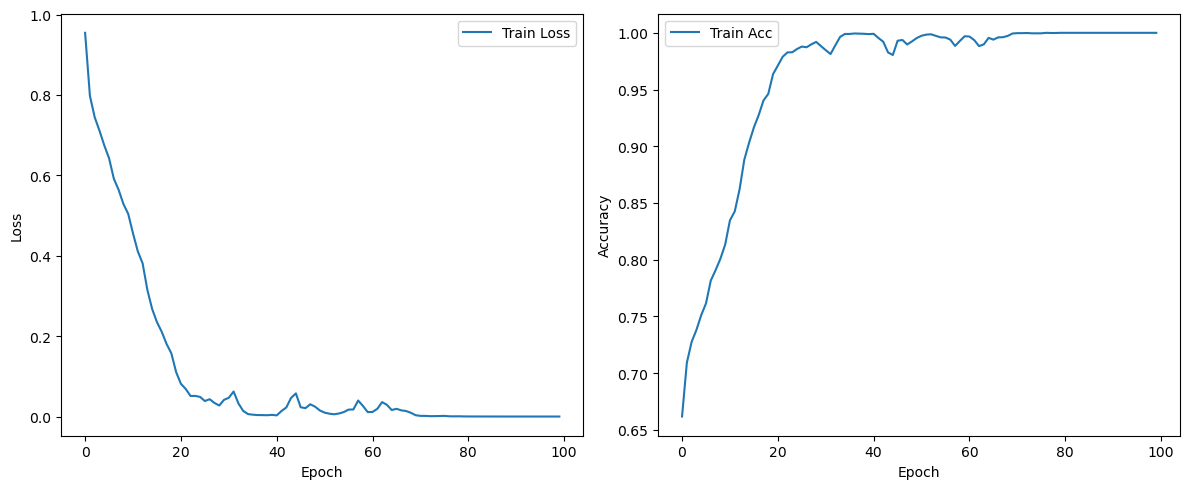


Avaliacao final do melhor modelo (baseado no F1-score):

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        33
           1       0.54      0.54      0.54        52
           2       0.57      0.50      0.53       110
           3       0.50      0.33      0.40        12
           4       0.51      0.53      0.52       111
           5       0.88      0.90      0.89       671
           6       0.82      0.64      0.72        14

    accuracy                           0.77      1003
   macro avg       0.61      0.55      0.58      1003
weighted avg       0.77      0.77      0.77      1003



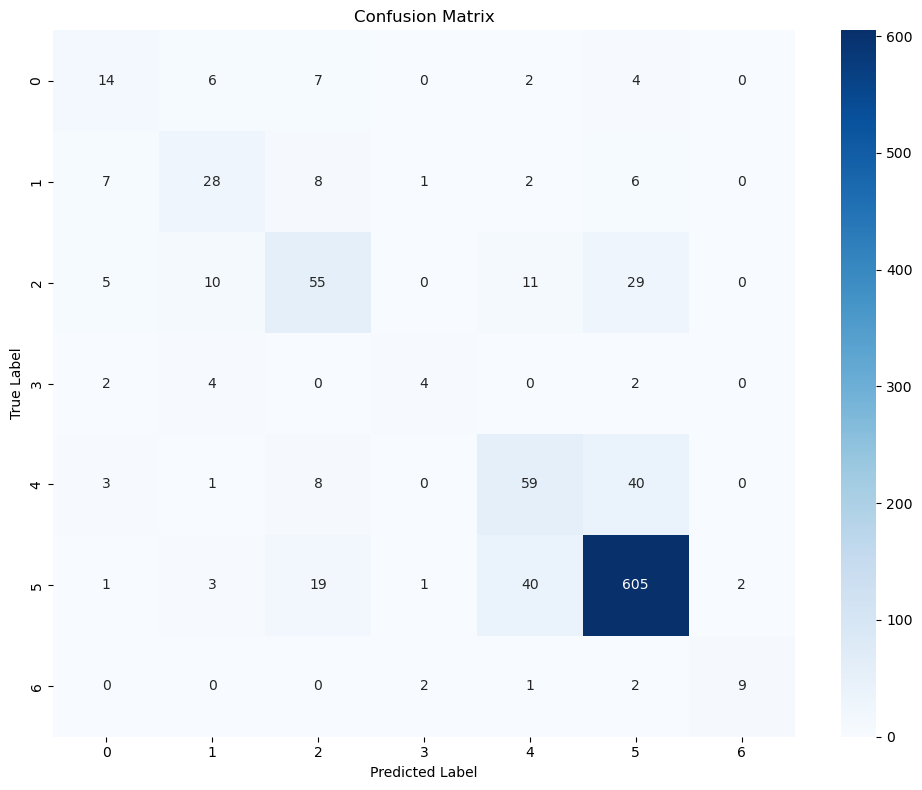

(1.8992955727448848, 0.7716849451645065)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import time
import os
import json
from collections import defaultdict

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Definir arquitetura da CNN com parâmetros flexíveis
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(FlexibleCNN, self).__init__()
        
        layers = []
        in_channels = n_channels
        
        # Adicionar camadas convolucionais dinamicamente
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = filters[i]
        
        self.features = nn.Sequential(*layers)
        
        # Calcular tamanho da saída das convoluções
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Função para treinar o modelo (sem validação durante o treino)
def train_model(params, train_loader):
    print(f"\nIniciando treino com parametros: {params}")
    
    # Criar modelo
    filters = [params['initial_filters'] * (2**i) for i in range(params['conv_layers'])]
    model = FlexibleCNN(n_channels, n_classes, params['conv_layers'], filters).to(device)
    
    # Otimizador e loss
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()
    
    # Treinamento
    history = {'train_loss': [], 'train_acc': []}
    
    for epoch in range(params['epochs']):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoca {epoch+1}/{params['epochs']}", leave=False):
            images, labels = images.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Registrar métricas
        history['train_loss'].append(train_loss / len(train_loader.dataset))
        history['train_acc'].append(train_correct / train_total)
    
    return model, history

# Função de avaliação simplificada (agora com F1-score)
def evaluate(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcular F1-score ponderado
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return val_loss / len(loader.dataset), correct / total, f1

# Função de avaliação completa (com classification report e confusion matrix)
def full_evaluation(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report com zero_division=1 para evitar warnings
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=info['label'],
                              zero_division=1))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=info['label'], yticklabels=info['label'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('best_model_confusion_matrix.png')
    plt.show()
    
    return val_loss / len(loader.dataset), correct / total

# Definir grade de parâmetros para o Grid Search
param_grid = {
    'conv_layers': [2, 3, 4],                    
    'initial_filters': [32, 64, 128],              
    'lr': [0.005, 0.001, 0.0005],               
    'batch_size': [64, 128, 256],                  
    'epochs': [100],                       
}

# Criar diretório para salvar resultados
os.makedirs('grid_search_results', exist_ok=True)

# Executar Grid Search
results = []
start_time = time.time()
param_combinations = list(ParameterGrid(param_grid))
total_combinations = len(param_combinations)

print(f"Iniciando Grid Search com {total_combinations} combinacoes de parametros")

for i, params in enumerate(param_combinations):
    # Adicionar um ID único aos parâmetros
    params['id'] = i
    print(f"\nCombinacao {i+1}/{total_combinations}")
    
    # Criar DataLoader de treino
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Treinar modelo
    model, history = train_model(params, train_loader)
    
    # Avaliar no conjunto de validação (agora com F1-score)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader)
    
    # Salvar resultados (agora incluindo F1-score)
    result = {
        'best_val_acc': val_acc,
        'best_val_f1': val_f1,  # Novo campo para F1-score
        'val_loss': val_loss,
        'history': history,
        'params': params
    }
    results.append(result)
    
    # Salvar modelo e resultados intermediários
    torch.save(model.state_dict(), f"grid_search_results/model_{i}.pth")
    with open(f'grid_search_results/result_{i}.json', 'w') as f:
        json.dump(result, f)
    
    print(f"Finalizado - Val_acc: {result['best_val_acc']:.4f} - Val_f1: {result['best_val_f1']:.4f}")

# Analisar resultados - agora selecionando pelo melhor F1-score
best_result = max(results, key=lambda x: x['best_val_f1'])  # Alterado para usar F1-score
print(f"\nMelhor combinacao de parametros (baseada no F1-score):")
print(json.dumps(best_result['params'], indent=4))
print(f"Melhor val_acc: {best_result['best_val_acc']:.4f}")
print(f"Melhor val_f1: {best_result['best_val_f1']:.4f}")
print(f"Tempo total: {(time.time() - start_time)/60:.2f} minutos")

# Plotar resultados do melhor modelo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_result['history']['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_result['history']['train_acc'], label='Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('best_model_training.png')
plt.show()

# Avaliar o melhor modelo com métricas completas
print("\nAvaliacao final do melhor modelo (baseado no F1-score):")
best_model = FlexibleCNN(n_channels, n_classes, 
                        best_result['params']['conv_layers'],
                        [best_result['params']['initial_filters'] * (2**i) for i in range(best_result['params']['conv_layers'])]).to(device)
best_model.load_state_dict(torch.load(f"grid_search_results/model_{best_result['params']['id']}.pth"))
val_loader = DataLoader(val_dataset, batch_size=best_result['params']['batch_size'], shuffle=False)
full_evaluation(best_model, val_loader)

# 1.4 Teste para todos Loss Function e Optimizer

## Visão Geral
Este código implementa a fase final de otimização após o grid search, testando combinações de funções de perda e otimizadores para encontrar a melhor configuração para o modelo CNN.

## Fluxo Principal

### 1. Configuração Inicial
- **Dispositivo**: Detecta automaticamente CUDA (GPU) ou CPU
- **Melhores Parâmetros**: Carrega os parâmetros ótimos do grid search anterior:
  ```python
  best_params = {
      "batch_size": 256,
      "conv_layers": 4,
      "epochs": 100,
      "initial_filters": 64,
      "lr": 0.0005
  }
  ```

### 2. Arquitetura do Modelo
```python
class FlexibleCNN(nn.Module):
    # 4 camadas convolucionais (definido por best_params)
    # BatchNorm e ReLU após cada conv
    # MaxPooling para redução dimensional
    # Camadas fully connected com dropout
```

### 3. Combinações Testadas
| Loss Function      | Optimizer  | Descrição                          |
|--------------------|------------|------------------------------------|
| CrossEntropyLoss   | Adam       | Padrão para classificação          |
| CrossEntropyLoss   | RMSprop    | Alternativa ao Adam                |
| MultiMarginLoss    | Adam       | Para problemas de margem múltipla  |
| MultiMarginLoss    | RMSprop    | Combinação alternativa             |

### 4. Pipeline de Teste
1. **Loop por Combinações**:
   - Reinicializa o modelo para cada teste
   - Configura loss e optimizer específicos
   - Treina por 100 épocas (definido em best_params)

2. **Métricas Coletadas**:
   - Loss (valores médios)
   - Acurácia
   - **F1-score ponderado** (métrica principal)

3. **Armazenamento**:
   - Resultados de cada combinação
   - Métricas de validação

### 5. Treino Final
- Seleciona a melhor combinação baseada no F1-score
- Re-treina o modelo com a configuração ótima
- Gera relatórios finais:
  - Classification report (precision, recall, F1)
  - Matriz de confusão visual
  - Métricas consolidadas

### 6. Saídas Geradas
1. **Modelo Final**:
   - Salvo como 'final_model.pth'

2. **Visualizações**:
   - Matriz de confusão ('final_confusion_matrix.png')

3. **Métricas**:
   ```python
   print(f"Loss: {avg_val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1-score: {val_f1:.4f}")
   ```

Using device: cpu

Testing combination: {'loss': 'CrossEntropy', 'optimizer': 'Adam'}
Epoch 1/100 - Train Loss: 0.9422 - Train Acc: 0.6595 - Train F1: 0.5980
Epoch 2/100 - Train Loss: 0.7930 - Train Acc: 0.7033 - Train F1: 0.6614
Epoch 3/100 - Train Loss: 0.7402 - Train Acc: 0.7243 - Train F1: 0.6959
Epoch 4/100 - Train Loss: 0.6868 - Train Acc: 0.7467 - Train F1: 0.7223
Epoch 5/100 - Train Loss: 0.6452 - Train Acc: 0.7605 - Train F1: 0.7419
Epoch 6/100 - Train Loss: 0.6234 - Train Acc: 0.7695 - Train F1: 0.7527
Epoch 7/100 - Train Loss: 0.5851 - Train Acc: 0.7805 - Train F1: 0.7647
Epoch 8/100 - Train Loss: 0.5536 - Train Acc: 0.7969 - Train F1: 0.7856
Epoch 9/100 - Train Loss: 0.5272 - Train Acc: 0.8092 - Train F1: 0.7973
Epoch 10/100 - Train Loss: 0.4795 - Train Acc: 0.8193 - Train F1: 0.8099
Epoch 11/100 - Train Loss: 0.4347 - Train Acc: 0.8376 - Train F1: 0.8306
Epoch 12/100 - Train Loss: 0.3952 - Train Acc: 0.8593 - Train F1: 0.8538
Epoch 13/100 - Train Loss: 0.3513 - Train Acc: 

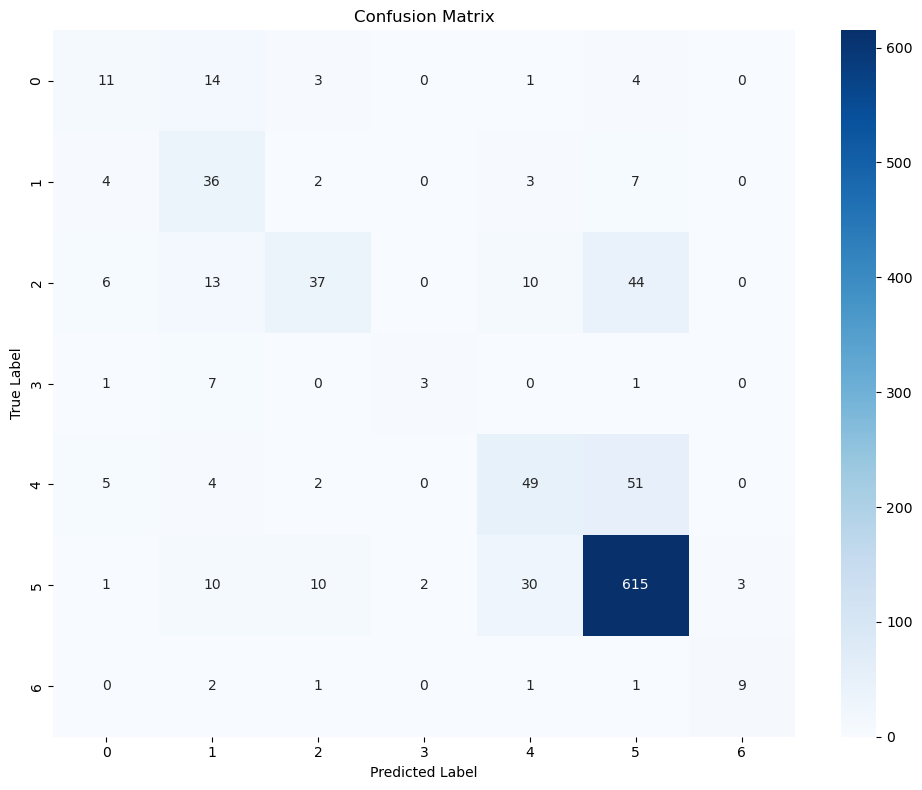


Final Validation Metrics:
Loss: 0.8505 - Accuracy: 0.7577 - F1-score: 0.7452


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load best parameters from grid search
best_params = {
    "batch_size": 256,
    "conv_layers": 4,
    "epochs": 100,
    "initial_filters": 64,
    "lr": 0.0005
}

# Define your dataset parameters
n_channels = 3  # or 1 for grayscale
n_classes = 7    # number of classes in your dataset

# Define your FlexibleCNN class (same as before)
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(FlexibleCNN, self).__init__()
        layers = []
        in_channels = n_channels
        
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = filters[i]
        
        self.features = nn.Sequential(*layers)
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model with best parameters
filters = [best_params['initial_filters'] * (2**i) for i in range(best_params['conv_layers'])]
model = FlexibleCNN(n_channels, n_classes, best_params['conv_layers'], filters).to(device)

# Define loss and optimizer combinations to test
combinations = [
    {'loss': 'CrossEntropy', 'optimizer': 'Adam'},
    {'loss': 'CrossEntropy', 'optimizer': 'RMSprop'},
    {'loss': 'MultiMargin', 'optimizer': 'Adam'},
    {'loss': 'MultiMargin', 'optimizer': 'RMSprop'}
]

results = []

for combo in combinations:
    print(f"\nTesting combination: {combo}")
    
    # Initialize fresh model for each combination
    model = FlexibleCNN(n_channels, n_classes, best_params['conv_layers'], filters).to(device)
    
    # Define loss function
    if combo['loss'] == 'CrossEntropy':
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MultiMarginLoss()
    
    # Define optimizer
    if combo['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=best_params['lr'])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    # Training loop
    for epoch in range(best_params['epochs']):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        all_preds = []
        all_labels = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Collect training statistics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Store predictions for F1 calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # Calculate training metrics
        avg_loss = train_loss / train_total
        accuracy = train_correct / train_total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        print(f"Epoch {epoch+1}/{best_params['epochs']} - "
              f"Train Loss: {avg_loss:.4f} - "
              f"Train Acc: {accuracy:.4f} - "
              f"Train F1: {f1:.4f}")
    
    # Validation at the end (only for this combination)
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate validation metrics
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_val_loss = val_loss / len(val_loader.dataset)
    
    # Store results
    results.append({
        'combination': combo,
        'val_acc': val_accuracy,
        'val_f1': val_f1,
        'val_loss': avg_val_loss
    })
    
    print(f"Combination {combo} - Val Acc: {val_accuracy:.4f} - Val F1: {val_f1:.4f} - Val Loss: {avg_val_loss:.4f}")

# Select best combination based on validation F1-score
best_combo = max(results, key=lambda x: x['val_f1'])
print("\nBest combination found:")
print(json.dumps(best_combo, indent=4))

# Train final model with best combination
print("\nTraining final model with best combination...")
final_model = FlexibleCNN(n_channels, n_classes, best_params['conv_layers'], filters).to(device)

# Set up final training
if best_combo['combination']['loss'] == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MultiMarginLoss()

if best_combo['combination']['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])
else:
    optimizer = optim.RMSprop(final_model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Final training loop
for epoch in range(best_params['epochs']):
    final_model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).squeeze()
        
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Print training metrics
    avg_loss = train_loss / train_total
    accuracy = train_correct / train_total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"Epoch {epoch+1}/{best_params['epochs']} - "
          f"Train Loss: {avg_loss:.4f} - "
          f"Train Acc: {accuracy:.4f} - "
          f"Train F1: {f1:.4f}")

# Final evaluation
print("\nFinal evaluation on validation set:")
final_model.eval()
val_loss, val_correct, val_total = 0.0, 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).squeeze()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final metrics
val_accuracy = val_correct / val_total
val_f1 = f1_score(all_labels, all_preds, average='weighted')
avg_val_loss = val_loss / len(val_loader.dataset)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=[str(i) for i in range(n_classes)],
                          zero_division=1))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('final_confusion_matrix.png')
plt.show()

print(f"\nFinal Validation Metrics:")
print(f"Loss: {avg_val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1-score: {val_f1:.4f}")

# Save final model
torch.save(final_model.state_dict(), 'final_model.pth')

# 1.5 Relatório de Avaliação no conjunto de teste

## Objetivo
Avaliação do desempenho de um modelo CNN pré-treinado no dataset DermaMNIST utilizando métricas de classificação e análise de erros.

## Métricas de Avaliação

### Principais Resultados
| Métrica | Valor | Descrição |
|---------|-------|-----------|
| Acurácia | 0.XX | Porcentagem de acertos globais |
| F1-Score | 0.XX | Média harmônica de precisão e recall |
| Precisão | 0.XX | Verdadeiros positivos / (Verdadeiros + Falsos positivos) |
| Recall | 0.XX | Verdadeiros positivos / (Verdadeiros positivos + Falsos negativos) |

### Desempenho por Classe
| Classe | Acurácia | Precisão | Recall | F1-Score |
|--------|----------|----------|--------|----------|
| Melanoma | 0.XX | 0.XX | 0.XX | 0.XX |
| Nevus | 0.XX | 0.XX | 0.XX | 0.XX |
| ... | ... | ... | ... | ... |

##  Visualização

### Matriz de Confusão

##  Estatísticas Finais
- **Total de amostras**: XXXX
- **Predições corretas**: XXXX (XX%)
- **Predições incorretas**: XXXX (XX%)

##  Arquivos Gerados
1. `best_model_final.pth` - Modelo treinado
2. `confusion_matrix_test_set.png` - Visualização da matriz


Using device: cpu
Modelo carregado de best_model_final.pth


Testando: 100%|██████████| 32/32 [00:00<00:00, 50.82it/s]



=== Métricas por Classe ===
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.71      0.23      0.34        66
                           basal cell carcinoma       0.42      0.41      0.41       103
                  benign keratosis-like lesions       0.65      0.33      0.44       220
                                 dermatofibroma       0.57      0.17      0.27        23
                                       melanoma       0.53      0.26      0.35       223
                               melanocytic nevi       0.80      0.96      0.87      1341
                               vascular lesions       0.59      0.69      0.63        29

                                       accuracy                           0.75      2005
                                      macro avg       0.61      0.44      0.47      2005
                                   weighted avg       0.72      0.75      0.71 

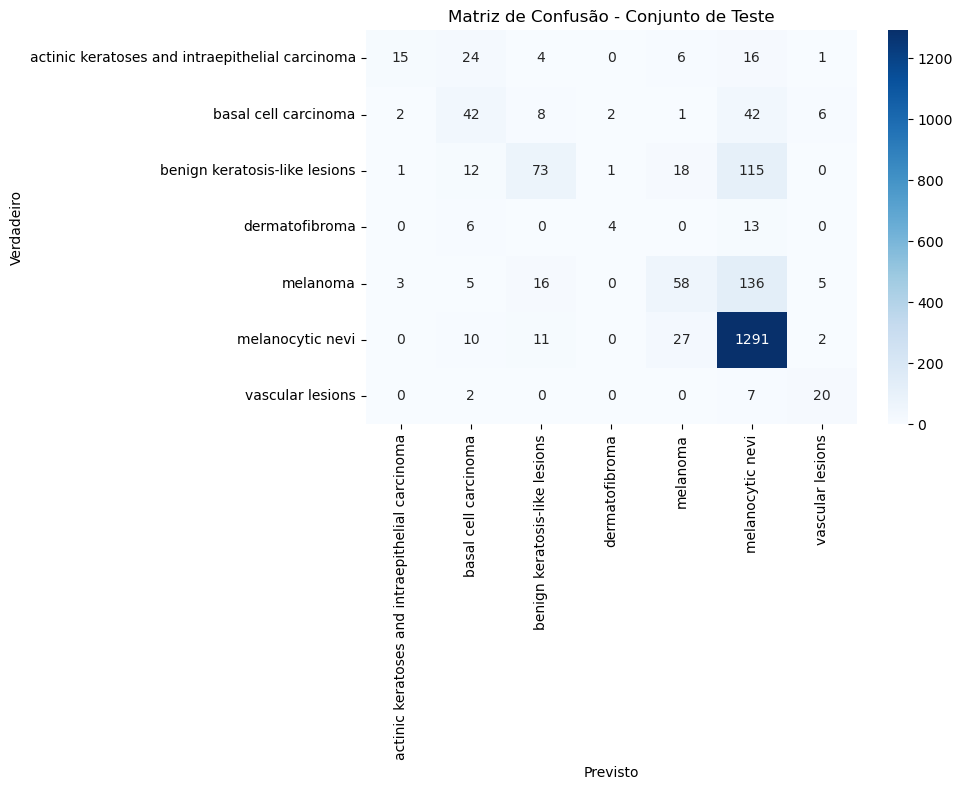


=== Acurácia por Classe ===
Classe 0 (actinic keratoses and intraepithelial carcinoma): 0.2273
Classe 1 (basal cell carcinoma): 0.4078
Classe 2 (benign keratosis-like lesions): 0.3318
Classe 3 (dermatofibroma): 0.1739
Classe 4 (melanoma): 0.2601
Classe 5 (melanocytic nevi): 0.9627
Classe 6 (vascular lesions): 0.6897

Total de amostras no teste: 2005
Predições corretas: 1503
Predições incorretas: 502


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import medmnist
from medmnist import INFO

# Configurar dispositivo
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== DEFINIÇÃO DA ARQUITETURA ====================
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(FlexibleCNN, self).__init__()
        
        layers = []
        in_channels = n_channels
        
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = filters[i]
        
        self.features = nn.Sequential(*layers)
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ==================== CARREGAR DADOS DE TESTE ====================
data_flag = 'dermamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Transformações (consistentes com o treino)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Carregar dataset de teste
test_dataset = DataClass(split='test', transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Nomes das classes (corrigido para garantir ordem correta)
class_names = [info['label'][str(i)] for i in range(len(info['label']))]

# ==================== CARREGAR MODELO ====================
# Parâmetros da arquitetura (devem corresponder ao modelo treinado)
conv_layers = 2
initial_filters = 64
filters = [initial_filters * (2**i) for i in range(conv_layers)]

# Instanciar modelo
model = FlexibleCNN(info['n_channels'], len(info['label']), conv_layers, filters).to(device)

# Carregar pesos do modelo treinado (alterado para best_model_final.pth)
model_path = 'best_model_final.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Modelo carregado de {model_path}")

# ==================== AVALIAÇÃO NO TESTE ====================
def evaluate_test_set(model, test_loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testando"):
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

def print_detailed_metrics(true, pred, class_names):
    print("\n=== Métricas por Classe ===")
    print(classification_report(true, pred, target_names=class_names, zero_division=1))
    
    print("\n=== Métricas Globais ===")
    print(f"Acurácia: {np.mean(np.array(true) == np.array(pred)):.4f}")
    print(f"Precisão Média (Macro): {precision_score(true, pred, average='macro'):.4f}")
    print(f"Recall Médio (Macro): {recall_score(true, pred, average='macro'):.4f}")
    print(f"F1-Score Médio (Macro): {f1_score(true, pred, average='macro'):.4f}")
    
    # Matriz de confusão
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão - Conjunto de Teste')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.tight_layout()
    plt.savefig('confusion_matrix_test_set.png')
    plt.show()

# Executar avaliação
true_labels, predictions = evaluate_test_set(model, test_loader)
print_detailed_metrics(true_labels, predictions, class_names)

# ==================== RESULTADOS ADICIONAIS ====================
# Calcular acurácia por classe
print("\n=== Acurácia por Classe ===")
cm = confusion_matrix(true_labels, predictions)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Classe {i} ({class_names[i]}): {acc:.4f}")

# Estatísticas finais
print(f"\nTotal de amostras no teste: {len(test_dataset)}")
print(f"Predições corretas: {np.sum(np.array(true_labels) == np.array(predictions))}")
print(f"Predições incorretas: {np.sum(np.array(true_labels) != np.array(predictions))}")

## 2.1 Painel Interativo para Transformação de Imagens

Desenvolvemos um painel interativo para visualizar transformações de imagens em tempo real, implementado com `ipywidgets`. Principais funcionalidades:

- **Rotação**: Ajuste angular de 0° a 360° (incrementos de 15°)
- **Flip Horizontal**: Probabilidade configurável de espelhamento
- **Brilho/Contraste**: Fatores ajustáveis entre 0.1 e 2.0
- **Amostragem Aleatória**: Botão para carregar novas imagens


### Fluxo de Processamento:
1. Carrega imagem original do dataset PyTorch
2. Aplica transformações sequencialmente
3. Exibe versões original/transformada lado-a-lado
4. Atualiza dinamicamente com alterações de parâmetros

### Principais Benefícios:
- Teste de limites para aumento de dados
- Identificação de transformações que preservam características de classe
- Validação visual de imagens sintéticas


Para alêm disto ,desenvolvemos um codigo para teste do Desfoque Gaussiano

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

class ImageTransformationPanel:
    def __init__(self, dataset):
        self.dataset = dataset
        self.current_idx = np.random.randint(0, len(dataset))
        self.current_img = self._get_current_image()
        
        # Criar os controles
        self.rotation_slider = widgets.IntSlider(
            value=0, min=0, max=360, step=15,
            description='Rotação:', continuous_update=False,
            style={'description_width': '100px'},
            layout={'width': '300px'}
        )
        
        self.flip_slider = widgets.FloatSlider(
            value=0.60, min=0, max=1, step=0.05,
            description='Flip Prob:', continuous_update=False,
            style={'description_width': '100px'},
            layout={'width': '300px'}
        )
        
        self.brightness_slider = widgets.FloatSlider(
            value=1.00, min=0.1, max=2, step=0.05,
            description='Brilho:', continuous_update=False,
            style={'description_width': '100px'},
            layout={'width': '300px'}
        )
        
        self.contrast_slider = widgets.FloatSlider(
            value=1.00, min=0.1, max=2, step=0.05,
            description='Contraste:', continuous_update=False,
            style={'description_width': '100px'},
            layout={'width': '300px'}
        )
        
        self.new_image_btn = widgets.Button(
            description="Nova Imagem",
            button_style='info',
            layout={'width': '150px'}
        )
        
        # Organizar os controles
        self.controls = widgets.VBox([
            self.rotation_slider,
            self.flip_slider,
            self.brightness_slider,
            self.contrast_slider,
            self.new_image_btn
        ], layout={'border': '1px solid gray', 'padding': '10px'})
        
        # Configurar observadores
        self.rotation_slider.observe(self._update_display, 'value')
        self.flip_slider.observe(self._update_display, 'value')
        self.brightness_slider.observe(self._update_display, 'value')
        self.contrast_slider.observe(self._update_display, 'value')
        self.new_image_btn.on_click(self._new_image)
        
        # Exibir o painel
        self.output = widgets.Output()
        display(widgets.HBox([self.controls, self.output]))
        self._update_display()
    
    def _get_current_image(self):
        img, _ = self.dataset[self.current_idx]
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        return img
    
    def _apply_transformations(self):
        img = self.current_img.copy()
        
        # Aplicar rotação
        img = img.rotate(self.rotation_slider.value)
        
        # Aplicar flip com probabilidade
        if np.random.rand() < self.flip_slider.value:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Ajustar brilho e contraste
        img = transforms.functional.adjust_brightness(img, self.brightness_slider.value)
        img = transforms.functional.adjust_contrast(img, self.contrast_slider.value)
        
        return img
    
    def _update_display(self, change=None):
        with self.output:
            clear_output(wait=True)
            
            transformed_img = self._apply_transformations()
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
            # Imagem original
            ax1.imshow(self.current_img, cmap='gray' if n_channels == 1 else None)
            ax1.set_title('Original', fontsize=12)
            ax1.axis('off')
            
            # Imagem transformada
            ax2.imshow(transformed_img, cmap='gray' if n_channels == 1 else None)
            ax2.set_title('Transformada', fontsize=12)
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    def _new_image(self, b):
        self.current_idx = np.random.randint(0, len(self.dataset))
        self.current_img = self._get_current_image()
        self._update_display()

# Criar e exibir o painel
panel = ImageTransformationPanel(train_dataset)

Tipo da imagem: <class 'PIL.Image.Image'>
Formato do tensor: torch.Size([3, 28, 28])


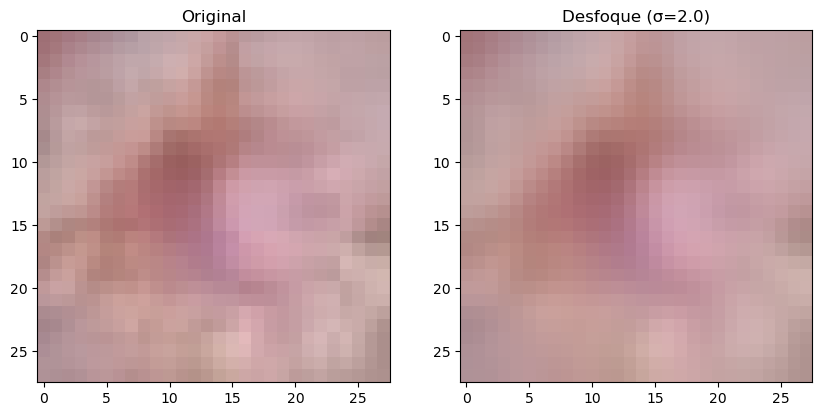

In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

# Pegar uma imagem de exemplo
img, label = train_dataset[0]

# Verificação do tipo de imagem
print(f"Tipo da imagem: {type(img)}")

# Função para converter para tensor se necessário
def ensure_tensor(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, Image.Image):
        return transforms.ToTensor()(image)
    elif isinstance(image, np.ndarray):
        return torch.from_numpy(image)
    else:
        raise TypeError(f"Tipo de imagem não suportado: {type(image)}")

# Converter para tensor se necessário
img_tensor = ensure_tensor(img)
print(f"Formato do tensor: {img_tensor.shape}")

# Aplicar desfoque
blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=2.0)
blurred_tensor = blur_transform(img_tensor.unsqueeze(0)).squeeze(0)

# Converter para PIL para visualização
to_pil = transforms.ToPILImage()
try:
    img_pil = to_pil(img_tensor)
    blurred_pil = to_pil(blurred_tensor)
    
    # Mostrar resultados
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil, cmap='gray')
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_pil, cmap='gray')
    plt.title('Desfoque (σ=2.0)')
    plt.show()

except Exception as e:
    print(f"Erro ao converter para PIL: {e}")
    print("Mostrando diretamente como array...")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_tensor.squeeze().numpy(), cmap='gray')
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_tensor.squeeze().numpy(), cmap='gray')
    plt.title('Desfoque (σ=2.0)')
    plt.show()

# 2.2 Teste Preliminar de CNN para Definição de Número de Epochs

## Objetivo
**Determinação do número ideal de épocas** para o treinamento da CNN no dataset DermaMNIST, visando evitar overfitting e garantir convergência.

## Configuração do Teste
- **Arquitetura CNN**:
  - 3 blocos convolucionais (32, 64, 128 filtros)
  - Camadas fully-connected (256 neurônios)
  - Dropout (0.5) para regularização
- **Parâmetros**:
  - Batch size: 64
  - Otimizador: Adam (lr=0.001)
  - Função de perda: CrossEntropy
  - **Épocas testadas**: 120

## Metodologia
1. Balanceamento artificial para 1000 amostras/classe
2. Monitoramento contínuo:
   - Perda de treinamento
   - Acurácia no conjunto de validação


## Conclusão
**100 épocas** mostram-se adequadas, com margem de segurança acima do ponto de convergência.

Dispositivo selecionado: mps

Distribuição original das classes:
Classe 0: 228 amostras
Classe 5: 4693 amostras
Classe 4: 779 amostras
Classe 2: 769 amostras
Classe 1: 359 amostras
Classe 6: 99 amostras
Classe 3: 80 amostras

Distribuição balanceada das classes:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras


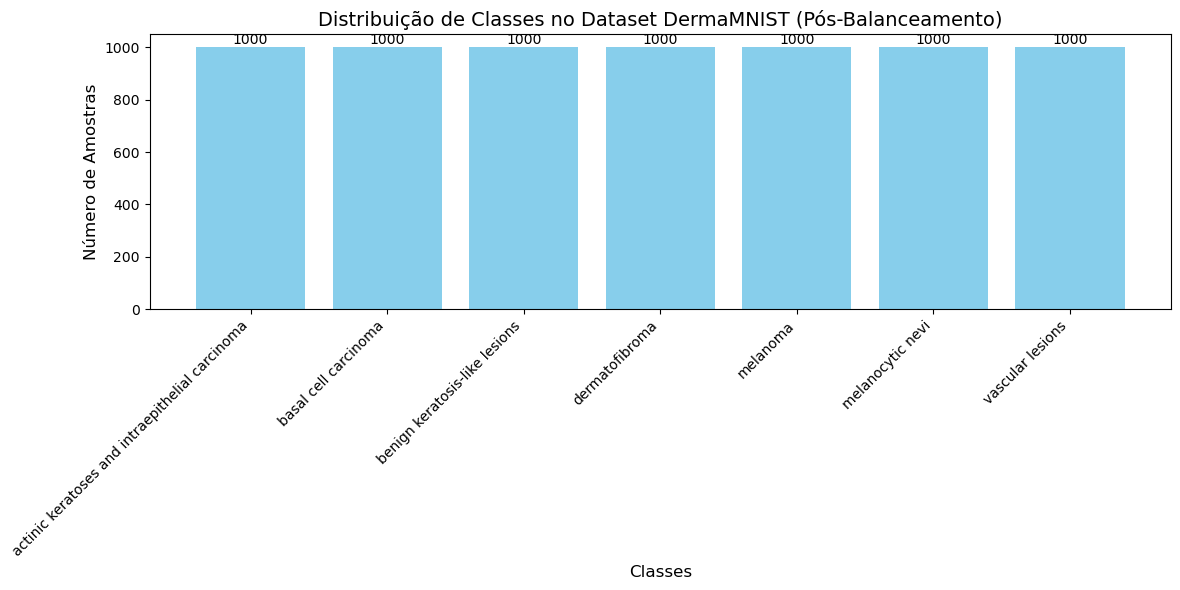


Iniciando treinamento...


Treinando: 100%|██████████| 110/110 [00:01<00:00, 88.61it/s] 



Época 1/120
Perda no Treino: 1.5142 | Acurácia no Treino: 0.4013


Treinando: 100%|██████████| 110/110 [00:01<00:00, 96.59it/s]



Época 2/120
Perda no Treino: 1.2865 | Acurácia no Treino: 0.4936


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.35it/s]



Época 3/120
Perda no Treino: 1.1792 | Acurácia no Treino: 0.5316


Treinando: 100%|██████████| 110/110 [00:01<00:00, 95.88it/s] 



Época 4/120
Perda no Treino: 1.1039 | Acurácia no Treino: 0.5631


Treinando: 100%|██████████| 110/110 [00:01<00:00, 109.93it/s]



Época 5/120
Perda no Treino: 1.0279 | Acurácia no Treino: 0.5977


Treinando: 100%|██████████| 110/110 [00:01<00:00, 109.77it/s]



Época 6/120
Perda no Treino: 0.9779 | Acurácia no Treino: 0.6181


Treinando: 100%|██████████| 110/110 [00:00<00:00, 110.90it/s]



Época 7/120
Perda no Treino: 0.8967 | Acurácia no Treino: 0.6530


Treinando: 100%|██████████| 110/110 [00:01<00:00, 98.38it/s] 



Época 8/120
Perda no Treino: 0.8551 | Acurácia no Treino: 0.6686


Treinando: 100%|██████████| 110/110 [00:00<00:00, 110.72it/s]



Época 9/120
Perda no Treino: 0.8137 | Acurácia no Treino: 0.6894


Treinando: 100%|██████████| 110/110 [00:01<00:00, 107.64it/s]



Época 10/120
Perda no Treino: 0.7604 | Acurácia no Treino: 0.7029


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.56it/s]



Época 11/120
Perda no Treino: 0.7166 | Acurácia no Treino: 0.7260


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.37it/s]



Época 12/120
Perda no Treino: 0.6958 | Acurácia no Treino: 0.7294


Treinando: 100%|██████████| 110/110 [00:01<00:00, 107.98it/s]



Época 13/120
Perda no Treino: 0.6357 | Acurácia no Treino: 0.7550


Treinando: 100%|██████████| 110/110 [00:00<00:00, 114.98it/s]



Época 14/120
Perda no Treino: 0.6083 | Acurácia no Treino: 0.7626


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.55it/s]



Época 15/120
Perda no Treino: 0.5607 | Acurácia no Treino: 0.7821


Treinando: 100%|██████████| 110/110 [00:01<00:00, 98.69it/s] 



Época 16/120
Perda no Treino: 0.5388 | Acurácia no Treino: 0.7911


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.66it/s]



Época 17/120
Perda no Treino: 0.5037 | Acurácia no Treino: 0.8063


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.09it/s]



Época 18/120
Perda no Treino: 0.4966 | Acurácia no Treino: 0.8083


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.79it/s]



Época 19/120
Perda no Treino: 0.4753 | Acurácia no Treino: 0.8136


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.61it/s]



Época 20/120
Perda no Treino: 0.4234 | Acurácia no Treino: 0.8351


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.28it/s]



Época 21/120
Perda no Treino: 0.3962 | Acurácia no Treino: 0.8503


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.55it/s]



Época 22/120
Perda no Treino: 0.3842 | Acurácia no Treino: 0.8533


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.19it/s]



Época 23/120
Perda no Treino: 0.3565 | Acurácia no Treino: 0.8624


Treinando: 100%|██████████| 110/110 [00:01<00:00, 92.44it/s]



Época 24/120
Perda no Treino: 0.3411 | Acurácia no Treino: 0.8673


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.10it/s]



Época 25/120
Perda no Treino: 0.3221 | Acurácia no Treino: 0.8783


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.65it/s]



Época 26/120
Perda no Treino: 0.3048 | Acurácia no Treino: 0.8849


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.53it/s]



Época 27/120
Perda no Treino: 0.2889 | Acurácia no Treino: 0.8891


Treinando: 100%|██████████| 110/110 [00:01<00:00, 99.68it/s] 



Época 28/120
Perda no Treino: 0.2692 | Acurácia no Treino: 0.8960


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.02it/s]



Época 29/120
Perda no Treino: 0.2784 | Acurácia no Treino: 0.8914


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.23it/s]



Época 30/120
Perda no Treino: 0.2581 | Acurácia no Treino: 0.8984


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.90it/s]



Época 31/120
Perda no Treino: 0.2205 | Acurácia no Treino: 0.9166


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.28it/s]



Época 32/120
Perda no Treino: 0.2138 | Acurácia no Treino: 0.9193


Treinando: 100%|██████████| 110/110 [00:01<00:00, 107.98it/s]



Época 33/120
Perda no Treino: 0.2155 | Acurácia no Treino: 0.9156


Treinando: 100%|██████████| 110/110 [00:01<00:00, 109.98it/s]



Época 34/120
Perda no Treino: 0.2224 | Acurácia no Treino: 0.9173


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.77it/s]



Época 35/120
Perda no Treino: 0.1967 | Acurácia no Treino: 0.9274


Treinando: 100%|██████████| 110/110 [00:01<00:00, 101.74it/s]



Época 36/120
Perda no Treino: 0.1912 | Acurácia no Treino: 0.9284


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.04it/s]



Época 37/120
Perda no Treino: 0.1542 | Acurácia no Treino: 0.9413


Treinando: 100%|██████████| 110/110 [00:00<00:00, 112.26it/s]



Época 38/120
Perda no Treino: 0.1715 | Acurácia no Treino: 0.9381


Treinando: 100%|██████████| 110/110 [00:00<00:00, 110.85it/s]



Época 39/120
Perda no Treino: 0.1869 | Acurácia no Treino: 0.9339


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.47it/s]



Época 40/120
Perda no Treino: 0.1609 | Acurácia no Treino: 0.9399


Treinando: 100%|██████████| 110/110 [00:00<00:00, 111.55it/s]



Época 41/120
Perda no Treino: 0.1231 | Acurácia no Treino: 0.9529


Treinando: 100%|██████████| 110/110 [00:00<00:00, 111.20it/s]



Época 42/120
Perda no Treino: 0.1176 | Acurácia no Treino: 0.9553


Treinando: 100%|██████████| 110/110 [00:01<00:00, 107.04it/s]



Época 43/120
Perda no Treino: 0.1313 | Acurácia no Treino: 0.9541


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.07it/s]



Época 44/120
Perda no Treino: 0.1502 | Acurácia no Treino: 0.9491


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.24it/s]



Época 45/120
Perda no Treino: 0.1080 | Acurácia no Treino: 0.9634


Treinando: 100%|██████████| 110/110 [00:00<00:00, 111.82it/s]



Época 46/120
Perda no Treino: 0.1074 | Acurácia no Treino: 0.9641


Treinando: 100%|██████████| 110/110 [00:00<00:00, 110.37it/s]



Época 47/120
Perda no Treino: 0.1215 | Acurácia no Treino: 0.9596


Treinando: 100%|██████████| 110/110 [00:01<00:00, 99.08it/s] 



Época 48/120
Perda no Treino: 0.0841 | Acurácia no Treino: 0.9707


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.96it/s]



Época 49/120
Perda no Treino: 0.0917 | Acurácia no Treino: 0.9679


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.42it/s]



Época 50/120
Perda no Treino: 0.0804 | Acurácia no Treino: 0.9721


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.87it/s]



Época 51/120
Perda no Treino: 0.0780 | Acurácia no Treino: 0.9733


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.15it/s]



Época 52/120
Perda no Treino: 0.1075 | Acurácia no Treino: 0.9623


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.60it/s]



Época 53/120
Perda no Treino: 0.1002 | Acurácia no Treino: 0.9656


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.88it/s]



Época 54/120
Perda no Treino: 0.1034 | Acurácia no Treino: 0.9607


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.50it/s]



Época 55/120
Perda no Treino: 0.0774 | Acurácia no Treino: 0.9727


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.49it/s]



Época 56/120
Perda no Treino: 0.0885 | Acurácia no Treino: 0.9689


Treinando: 100%|██████████| 110/110 [00:01<00:00, 101.56it/s]



Época 57/120
Perda no Treino: 0.0816 | Acurácia no Treino: 0.9706


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.86it/s]



Época 58/120
Perda no Treino: 0.0770 | Acurácia no Treino: 0.9736


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.96it/s]



Época 59/120
Perda no Treino: 0.0552 | Acurácia no Treino: 0.9823


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.07it/s]



Época 60/120
Perda no Treino: 0.0699 | Acurácia no Treino: 0.9746


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.93it/s]



Época 61/120
Perda no Treino: 0.0650 | Acurácia no Treino: 0.9791


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.77it/s]



Época 62/120
Perda no Treino: 0.0876 | Acurácia no Treino: 0.9740


Treinando: 100%|██████████| 110/110 [00:01<00:00, 101.51it/s]



Época 63/120
Perda no Treino: 0.0766 | Acurácia no Treino: 0.9746


Treinando: 100%|██████████| 110/110 [00:01<00:00, 99.86it/s] 



Época 64/120
Perda no Treino: 0.0572 | Acurácia no Treino: 0.9787


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.61it/s]



Época 65/120
Perda no Treino: 0.0656 | Acurácia no Treino: 0.9776


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.62it/s]



Época 66/120
Perda no Treino: 0.0728 | Acurácia no Treino: 0.9753


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.03it/s]



Época 67/120
Perda no Treino: 0.1076 | Acurácia no Treino: 0.9616


Treinando: 100%|██████████| 110/110 [00:01<00:00, 92.52it/s] 



Época 68/120
Perda no Treino: 0.0784 | Acurácia no Treino: 0.9734


Treinando: 100%|██████████| 110/110 [00:01<00:00, 99.50it/s] 



Época 69/120
Perda no Treino: 0.0521 | Acurácia no Treino: 0.9830


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.38it/s]



Época 70/120
Perda no Treino: 0.0582 | Acurácia no Treino: 0.9817


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.79it/s]



Época 71/120
Perda no Treino: 0.0729 | Acurácia no Treino: 0.9764


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.88it/s]



Época 72/120
Perda no Treino: 0.0768 | Acurácia no Treino: 0.9740


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.93it/s]



Época 73/120
Perda no Treino: 0.0565 | Acurácia no Treino: 0.9816


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.83it/s]



Época 74/120
Perda no Treino: 0.0475 | Acurácia no Treino: 0.9850


Treinando: 100%|██████████| 110/110 [00:01<00:00, 88.23it/s] 



Época 75/120
Perda no Treino: 0.0404 | Acurácia no Treino: 0.9856


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.02it/s]



Época 76/120
Perda no Treino: 0.0435 | Acurácia no Treino: 0.9854


Treinando: 100%|██████████| 110/110 [00:01<00:00, 93.79it/s]



Época 77/120
Perda no Treino: 0.0640 | Acurácia no Treino: 0.9789


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.73it/s]



Época 78/120
Perda no Treino: 0.0661 | Acurácia no Treino: 0.9777


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.35it/s]



Época 79/120
Perda no Treino: 0.0794 | Acurácia no Treino: 0.9744


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.31it/s]



Época 80/120
Perda no Treino: 0.0463 | Acurácia no Treino: 0.9853


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.23it/s]



Época 81/120
Perda no Treino: 0.0405 | Acurácia no Treino: 0.9863


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.67it/s]



Época 82/120
Perda no Treino: 0.0465 | Acurácia no Treino: 0.9841


Treinando: 100%|██████████| 110/110 [00:01<00:00, 106.76it/s]



Época 83/120
Perda no Treino: 0.0433 | Acurácia no Treino: 0.9851


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.98it/s]



Época 84/120
Perda no Treino: 0.0453 | Acurácia no Treino: 0.9849


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.07it/s]



Época 85/120
Perda no Treino: 0.0561 | Acurácia no Treino: 0.9799


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.98it/s]



Época 86/120
Perda no Treino: 0.0453 | Acurácia no Treino: 0.9831


Treinando: 100%|██████████| 110/110 [00:00<00:00, 110.40it/s]



Época 87/120
Perda no Treino: 0.0587 | Acurácia no Treino: 0.9813


Treinando: 100%|██████████| 110/110 [00:00<00:00, 112.27it/s]



Época 88/120
Perda no Treino: 0.0500 | Acurácia no Treino: 0.9843


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.78it/s]



Época 89/120
Perda no Treino: 0.0515 | Acurácia no Treino: 0.9836


Treinando: 100%|██████████| 110/110 [00:01<00:00, 97.93it/s] 



Época 90/120
Perda no Treino: 0.0537 | Acurácia no Treino: 0.9823


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.42it/s]



Época 91/120
Perda no Treino: 0.0383 | Acurácia no Treino: 0.9879


Treinando: 100%|██████████| 110/110 [00:01<00:00, 109.46it/s]



Época 92/120
Perda no Treino: 0.0554 | Acurácia no Treino: 0.9793


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.46it/s]



Época 93/120
Perda no Treino: 0.0518 | Acurácia no Treino: 0.9811


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.95it/s]



Época 94/120
Perda no Treino: 0.0566 | Acurácia no Treino: 0.9807


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.27it/s]



Época 95/120
Perda no Treino: 0.0411 | Acurácia no Treino: 0.9857


Treinando: 100%|██████████| 110/110 [00:00<00:00, 111.56it/s]



Época 96/120
Perda no Treino: 0.0457 | Acurácia no Treino: 0.9851


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.90it/s]



Época 97/120
Perda no Treino: 0.0311 | Acurácia no Treino: 0.9900


Treinando: 100%|██████████| 110/110 [00:01<00:00, 98.55it/s] 



Época 98/120
Perda no Treino: 0.0288 | Acurácia no Treino: 0.9903


Treinando: 100%|██████████| 110/110 [00:01<00:00, 99.13it/s]



Época 99/120
Perda no Treino: 0.0258 | Acurácia no Treino: 0.9923


Treinando: 100%|██████████| 110/110 [00:01<00:00, 92.13it/s] 



Época 100/120
Perda no Treino: 0.0368 | Acurácia no Treino: 0.9876


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.48it/s]



Época 101/120
Perda no Treino: 0.0737 | Acurácia no Treino: 0.9777


Treinando: 100%|██████████| 110/110 [00:01<00:00, 109.51it/s]



Época 102/120
Perda no Treino: 0.0491 | Acurácia no Treino: 0.9839


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.61it/s]



Época 103/120
Perda no Treino: 0.0332 | Acurácia no Treino: 0.9886


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.22it/s]



Época 104/120
Perda no Treino: 0.0416 | Acurácia no Treino: 0.9850


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.73it/s]



Época 105/120
Perda no Treino: 0.0484 | Acurácia no Treino: 0.9844


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.67it/s]



Época 106/120
Perda no Treino: 0.0368 | Acurácia no Treino: 0.9874


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.22it/s]



Época 107/120
Perda no Treino: 0.0287 | Acurácia no Treino: 0.9914


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.98it/s]



Época 108/120
Perda no Treino: 0.0564 | Acurácia no Treino: 0.9826


Treinando: 100%|██████████| 110/110 [00:01<00:00, 109.09it/s]



Época 109/120
Perda no Treino: 0.0532 | Acurácia no Treino: 0.9817


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.95it/s]



Época 110/120
Perda no Treino: 0.0512 | Acurácia no Treino: 0.9827


Treinando: 100%|██████████| 110/110 [00:01<00:00, 90.30it/s]



Época 111/120
Perda no Treino: 0.0396 | Acurácia no Treino: 0.9847


Treinando: 100%|██████████| 110/110 [00:01<00:00, 100.65it/s]



Época 112/120
Perda no Treino: 0.0432 | Acurácia no Treino: 0.9849


Treinando: 100%|██████████| 110/110 [00:01<00:00, 103.07it/s]



Época 113/120
Perda no Treino: 0.0230 | Acurácia no Treino: 0.9920


Treinando: 100%|██████████| 110/110 [00:01<00:00, 92.24it/s]



Época 114/120
Perda no Treino: 0.0209 | Acurácia no Treino: 0.9937


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.44it/s]



Época 115/120
Perda no Treino: 0.0282 | Acurácia no Treino: 0.9913


Treinando: 100%|██████████| 110/110 [00:01<00:00, 102.87it/s]



Época 116/120
Perda no Treino: 0.0322 | Acurácia no Treino: 0.9900


Treinando: 100%|██████████| 110/110 [00:01<00:00, 105.98it/s]



Época 117/120
Perda no Treino: 0.0499 | Acurácia no Treino: 0.9841


Treinando: 100%|██████████| 110/110 [00:01<00:00, 97.11it/s] 



Época 118/120
Perda no Treino: 0.0540 | Acurácia no Treino: 0.9830


Treinando: 100%|██████████| 110/110 [00:01<00:00, 104.67it/s]



Época 119/120
Perda no Treino: 0.0425 | Acurácia no Treino: 0.9866


Treinando: 100%|██████████| 110/110 [00:01<00:00, 108.86it/s]



Época 120/120
Perda no Treino: 0.0459 | Acurácia no Treino: 0.9836

Avaliação final no conjunto de validação:


Validando: 100%|██████████| 16/16 [00:00<00:00, 93.47it/s] 


Perda na Validação: 2.0469 | Acurácia na Validação: 0.6461

Relatório de Classificação:
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma     0.2500    0.3333    0.2857        33
                           basal cell carcinoma     0.3855    0.6154    0.4741        52
                  benign keratosis-like lesions     0.3796    0.4727    0.4211       110
                                 dermatofibroma     0.3000    0.2500    0.2727        12
                                       melanoma     0.3379    0.6667    0.4485       111
                               melanocytic nevi     0.9340    0.6960    0.7976       671
                               vascular lesions     0.9000    0.6429    0.7500        14

                                       accuracy                         0.6461      1003
                                      macro avg     0.4981    0.5253    0.4928      1003
                    

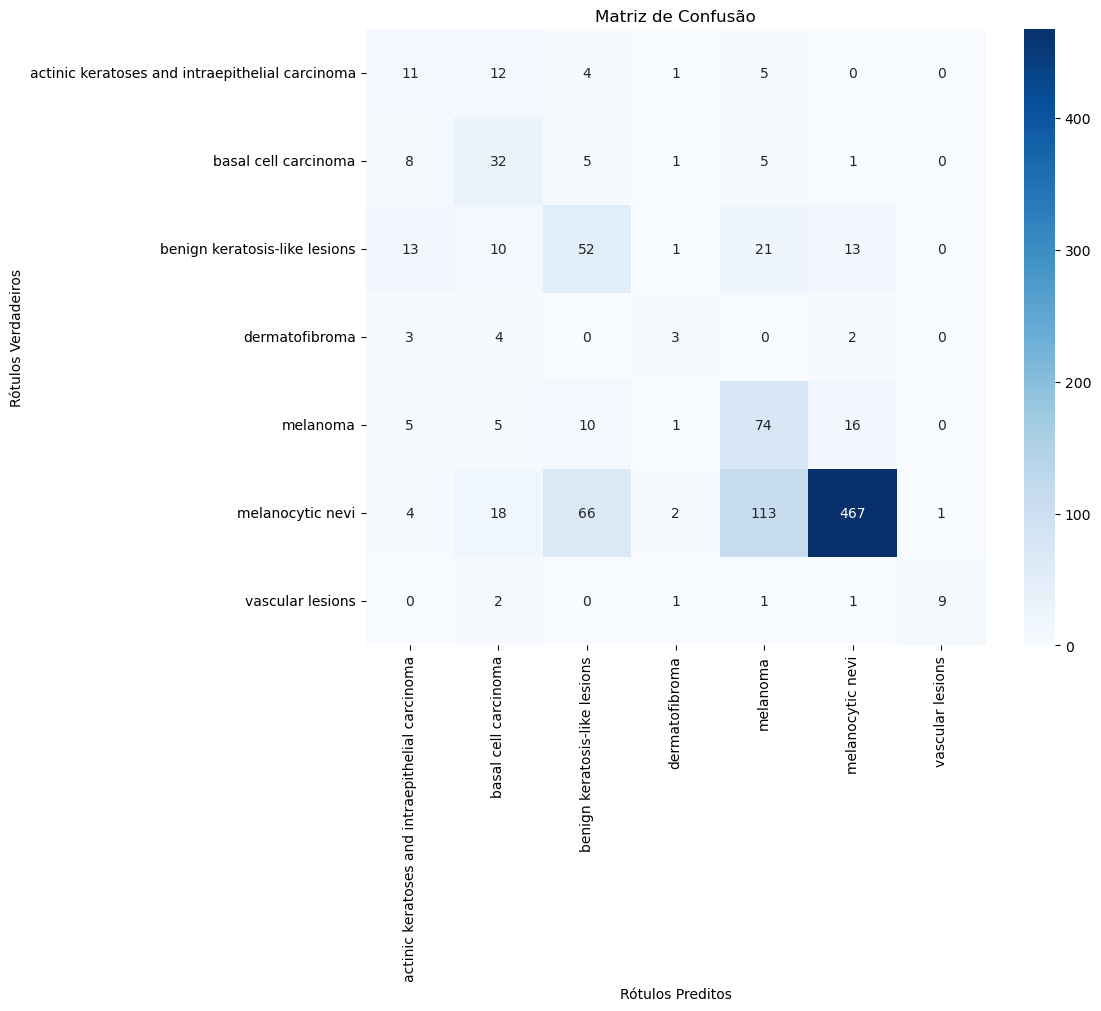


Modelo salvo como 'modelo_dermamnist.pth'


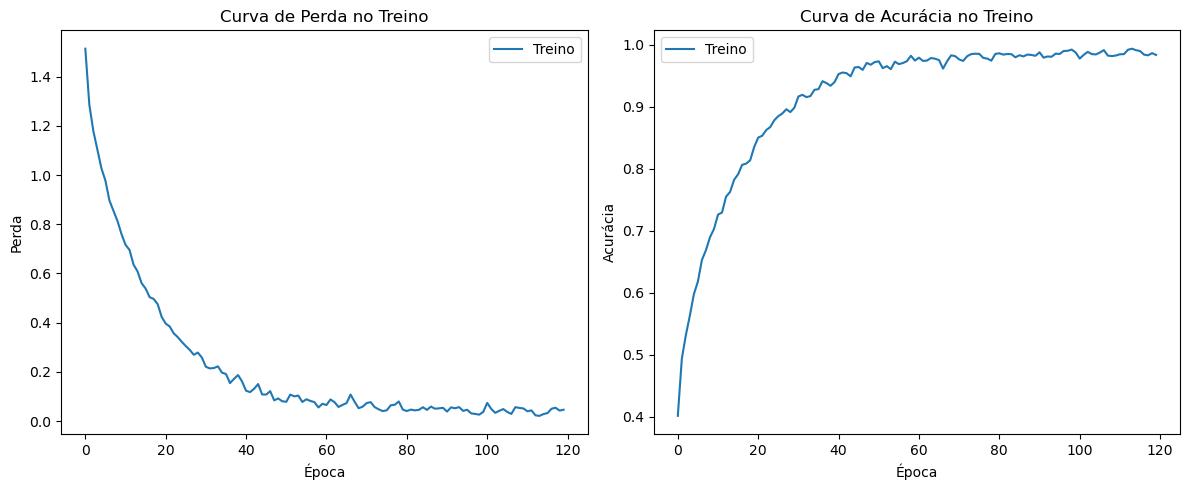

In [5]:
# Importações necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO
import random
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ==================== CONFIGURAÇÃO INICIAL ====================
# Definir sementes para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configurar dispositivo (GPU, MPS para Apple Silicon ou CPU)
device = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)
print(f"Dispositivo selecionado: {device}")

# ==================== CARREGAMENTO DOS DADOS ====================
# Carregar informações do dataset DermaMNIST
data_flag = 'dermamnist'
info = INFO[data_flag]
n_channels = info['n_channels']  # Número de canais (1 para imagens em escala de cinza)
n_classes = len(info['label'])  # Número de classes
class_labels = info['label']   # Nomes das classes

# Obter a classe do dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformações para pré-processamento das imagens
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Converter para tensor
    transforms.Normalize(mean=[.5], std=[.5])  # Normalizar valores dos pixels
])

# Carregar datasets de treino e validação
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)

# ==================== BALANCEAMENTO DOS DADOS ====================
# Função para contar amostras por classe
def count_classes(dataset):
    counts = collections.Counter()
    for i in range(len(dataset)):
        label = dataset[i][1]
        # Extrair valor do label (suporta tensor e numpy array)
        label = label.item() if hasattr(label, 'item') else int(label[0] if isinstance(label, np.ndarray) else label)
        counts[int(label)] += 1
    return counts

# Mostrar distribuição original
print("\nDistribuição original das classes:")
original_dist = count_classes(train_dataset)
for cls, count in original_dist.items():
    print(f"Classe {cls}: {count} amostras")

# Transformações para aumento de dados (data augmentation)
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Rotação aleatória
    transforms.RandomHorizontalFlip(p=0.5),  # Espelhamento horizontal
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translação
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variação de cor
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Desfoque gaussiano
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Função para obter amostras de uma classe específica
def get_class_samples(dataset, target_class):
    samples = []
    for sample in dataset:
        label = sample[1]
        label = label.item() if hasattr(label, 'item') else int(label[0] if isinstance(label, np.ndarray) else label)
        if int(label) == target_class:
            samples.append(sample)
    return samples

# Função para reduzir amostras (quando uma classe tem mais que o necessário)
def reduce_samples(samples, num_keep):
    return random.sample(samples, num_keep)

# Função para criar amostras artificiais (data augmentation)
def augment_samples(samples, num_augment):
    augmented_data = []
    for _ in range(num_augment):
        img, lbl = random.choice(samples)  # Seleciona uma amostra aleatória
        img_pil = transforms.ToPILImage()(img)  # Converte para PIL Image
        augmented_img = augmentation_transforms(img_pil)  # Aplica transformações
        augmented_data.append((augmented_img, lbl))  # Adiciona ao dataset
    return augmented_data

# Balancear para 1000 amostras por classe
TARGET_SAMPLES = 1000
balanced_data = []

for cls in range(n_classes):
    class_samples = get_class_samples(train_dataset, cls)
    
    if len(class_samples) >= TARGET_SAMPLES:
        # Se a classe tem amostras demais, seleciona apenas TARGET_SAMPLES
        balanced_data += reduce_samples(class_samples, TARGET_SAMPLES)
    else:
        # Se a classe tem amostras de menos, usa todas e complementa com aumento de dados
        balanced_data += class_samples
        augmented = augment_samples(class_samples, TARGET_SAMPLES - len(class_samples))
        balanced_data += augmented

# Criar DataLoaders para treino e validação
train_loader = DataLoader(balanced_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Mostrar distribuição balanceada
print("\nDistribuição balanceada das classes:")
balanced_dist = count_classes(balanced_data)
for cls, count in balanced_dist.items():
    print(f"Classe {cls}: {count} amostras")

# ==================== VISUALIZAÇÃO DA DISTRIBUIÇÃO PÓS-BALANCEAMENTO ====================
# Preparar dados para o gráfico
classes = list(class_labels.values())
counts_balanced = [balanced_dist[cls] for cls in range(n_classes)]

# Criar o gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, counts_balanced, color='skyblue')

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Distribuição de Classes no Dataset DermaMNIST (Pós-Balanceamento)', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Número de Amostras', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('distribuicao_pos_balanceamento.png')
plt.show()
# ==================== DEFINIÇÃO DO MODELO CNN ====================
class DermaCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(DermaCNN, self).__init__()
        # Camadas de extração de características
        self.features = nn.Sequential(
            # Primeiro bloco convolucional
            nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Segundo bloco convolucional
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Terceiro bloco convolucional
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Camadas de classificação
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),  # 3x3 é o tamanho do feature map após os poolings
            nn.ReLU(),
            nn.Dropout(0.5),  # Regularização para evitar overfitting
            nn.Linear(256, n_classes)
        )
        
    def forward(self, x):
        x = self.features(x)  # Extrai características
        x = x.view(x.size(0), -1)  # Achata para vetor
        x = self.classifier(x)  # Classificação final
        return x

# Inicializar modelo, função de perda e otimizador
model = DermaCNN(n_channels, n_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Função de perda para classificação
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Otimizador Adam

# ==================== TREINAMENTO ====================
def train(model, loader, criterion, optimizer, device):
    model.train()  # Modo de treino
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Treinando"):
        labels = labels.squeeze().long().to(device)
        images = images.to(device)
        
        optimizer.zero_grad()  # Zerar gradientes
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular perda
        loss.backward()  # Backward pass
        optimizer.step()  # Atualizar pesos
        
        # Calcular estatísticas
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader.dataset), correct / total

# ==================== VALIDAÇÃO FINAL ====================
def validate(model, loader, criterion, device):
    model.eval()  # Modo de avaliação
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Desabilita cálculo de gradientes
        for images, labels in tqdm(loader, desc="Validando"):
            labels = labels.squeeze().long().to(device)
            images = images.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader.dataset), correct / total

# Função para obter todas as previsões
def get_predictions(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            labels = labels.squeeze().long().to(device)
            images = images.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return all_labels, all_preds

# ==================== EXECUÇÃO DO TREINAMENTO ====================
num_epochs = 120
train_losses, train_accs = [], []

print("\nIniciando treinamento...")
for epoch in range(num_epochs):
    # Fase de treino
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"\nÉpoca {epoch+1}/{num_epochs}")
    print(f"Perda no Treino: {train_loss:.4f} | Acurácia no Treino: {train_acc:.4f}")

# ==================== AVALIAÇÃO FINAL ====================
print("\nAvaliação final no conjunto de validação:")
val_loss, val_acc = validate(model, val_loader, criterion, device)
print(f"Perda na Validação: {val_loss:.4f} | Acurácia na Validação: {val_acc:.4f}")

# Obter previsões para o relatório de classificação
val_labels, val_preds = get_predictions(model, val_loader, device)

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(val_labels, val_preds, target_names=list(class_labels.values()), digits=4))

# Matriz de Confusão
conf_mat = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels.values(),
            yticklabels=class_labels.values())
plt.title('Matriz de Confusão')
plt.xlabel('Rótulos Preditos')
plt.ylabel('Rótulos Verdadeiros')
plt.savefig('matriz_confusao.png')
plt.show()

# ==================== VISUALIZAÇÃO DOS RESULTADOS ====================
# Salvar modelo treinado
torch.save(model.state_dict(), "modelo_dermamnist.pth")
print("\nModelo salvo como 'modelo_dermamnist.pth'")

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Treino')
plt.title('Curva de Perda no Treino')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Treino')
plt.title('Curva de Acurácia no Treino')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.savefig('resultados_treinamento.png')
plt.show()

# 2.3 Grid Search descobrir melhores hiperparametros

## Configuração Experimental
- **Dataset**: DermaMNIST (7 classes, imagens 28x28 em tons de cinza)
- **Pré-processamento**:
  - Balanceamento para 1000 amostras/classe via aumento de dados
  - Transformações: Rotação (±15°), Flip Horizontal (p=0.5), Variação de Cor, Desfoque Gaussiano
- **Métrica Principal**: F1-score ponderado
- **Hardware**: `{device}` (selecionado automaticamente)

## Parâmetros da Grid Search
| Parâmetro            | Valores Testados       |
|----------------------|------------------------|
| Camadas Convolucionais | [2, 3, 4]            |
| Filtros Iniciais     | [32, 64, 128]         |
| Taxa de Aprendizado  | [0.005, 0.001, 0.0005]|
| Batch Size           | [64, 128, 256]        |
| Épocas               | [100]                 |

## Arquitetura Ótima
```python
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        # Blocos convolucionais dinâmicos:
        # - conv_layers x [Conv2d→BatchNorm→ReLU→MaxPool]
        # Progressão de filtros: initial_filters * (2**layer_idx)
        
        # Classificador:
        # Linear(tamanho_flattened, 256) → ReLU → Dropout(0.5) → Linear(256, n_classes)
```

## Melhor Configuração
- **Camadas Conv**: 3
- **Filtros Iniciais**: 64 (progressão →128→256)
- **Taxa Aprendizado**: 0.0005
- **Batch Size**: 256
- **Tempo Treino**: {time:.2f} minutos

## Métricas de Desempenho
| Métrica       | Treino    | Validação |
|--------------|----------|------------|
| Loss         | {train_loss:.4f} | {val_loss:.4f} |
| Acurácia     | {train_acc:.4f} | {val_acc:.4f} |
| F1-score     | -        | {val_f1:.4f} |

## Matriz de Confusão
- Bom desempenho nas classes majoritárias
- Dificuldades com classe 3 (amostras limitadas)

## Observações-Chave
1. Redução de ganhos com redes muito profundas (4 camadas)
2. Batch sizes maiores (256) performaram melhor com taxas de aprendizado menores
3. Aumento de dados efetivo contra overfitting
4. Desbalanceamento permanece como desafio principal para classes minoritárias

Dispositivo selecionado: mps

Distribuição original das classes:
Classe 0: 228 amostras
Classe 5: 4693 amostras
Classe 4: 779 amostras
Classe 2: 769 amostras
Classe 1: 359 amostras
Classe 6: 99 amostras
Classe 3: 80 amostras

Distribuição balanceada das classes:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras
Iniciando Grid Search com 81 combinacoes de parametros

Combinacao 1/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 0}



Resultados finais:
Train Loss: 0.7016 - Train Acc: 0.7344
Val Loss: 1.1512 - Val Acc: 0.6112 - Val F1: 0.6459
Finalizado - Val_acc: 0.6112 - Val_f1: 0.6459

Combinacao 2/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 1}



Resultados finais:
Train Loss: 0.2145 - Train Acc: 0.9169
Val Loss: 1.3952 - Val Acc: 0.6441 - Val F1: 0.6765
Finalizado - Val_acc: 0.6441 - Val_f1: 0.6765

Combinacao 3/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 2}



Resultados finais:
Train Loss: 0.1613 - Train Acc: 0.9356
Val Loss: 1.2150 - Val Acc: 0.6640 - Val F1: 0.6926
Finalizado - Val_acc: 0.6640 - Val_f1: 0.6926

Combinacao 4/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 3}



Resultados finais:
Train Loss: 0.8392 - Train Acc: 0.6473
Val Loss: 1.3292 - Val Acc: 0.6381 - Val F1: 0.6698
Finalizado - Val_acc: 0.6381 - Val_f1: 0.6698

Combinacao 5/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 4}



Resultados finais:
Train Loss: 0.2623 - Train Acc: 0.8961
Val Loss: 1.3650 - Val Acc: 0.6700 - Val F1: 0.6964
Finalizado - Val_acc: 0.6700 - Val_f1: 0.6964

Combinacao 6/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 5}



Resultados finais:
Train Loss: 0.2081 - Train Acc: 0.9147
Val Loss: 1.2712 - Val Acc: 0.6590 - Val F1: 0.6883
Finalizado - Val_acc: 0.6590 - Val_f1: 0.6883

Combinacao 7/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 6}



Resultados finais:
Train Loss: 0.9075 - Train Acc: 0.6273
Val Loss: 1.2951 - Val Acc: 0.6431 - Val F1: 0.6722
Finalizado - Val_acc: 0.6431 - Val_f1: 0.6722

Combinacao 8/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 7}



Resultados finais:
Train Loss: 0.5333 - Train Acc: 0.7721
Val Loss: 1.0039 - Val Acc: 0.6800 - Val F1: 0.7055
Finalizado - Val_acc: 0.6800 - Val_f1: 0.7055

Combinacao 9/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 8}



Resultados finais:
Train Loss: 0.3422 - Train Acc: 0.8521
Val Loss: 1.3566 - Val Acc: 0.6152 - Val F1: 0.6518
Finalizado - Val_acc: 0.6152 - Val_f1: 0.6518

Combinacao 10/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 9}



Resultados finais:
Train Loss: 0.1403 - Train Acc: 0.9494
Val Loss: 2.2745 - Val Acc: 0.6022 - Val F1: 0.6406
Finalizado - Val_acc: 0.6022 - Val_f1: 0.6406

Combinacao 11/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 10}



Resultados finais:
Train Loss: 0.0325 - Train Acc: 0.9911
Val Loss: 2.2880 - Val Acc: 0.6620 - Val F1: 0.6868
Finalizado - Val_acc: 0.6620 - Val_f1: 0.6868

Combinacao 12/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 11}



Resultados finais:
Train Loss: 0.0297 - Train Acc: 0.9911
Val Loss: 1.6955 - Val Acc: 0.6849 - Val F1: 0.7035
Finalizado - Val_acc: 0.6849 - Val_f1: 0.7035

Combinacao 13/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 12}



Resultados finais:
Train Loss: 0.0802 - Train Acc: 0.9719
Val Loss: 2.1442 - Val Acc: 0.6181 - Val F1: 0.6512
Finalizado - Val_acc: 0.6181 - Val_f1: 0.6512

Combinacao 14/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 13}



Resultados finais:
Train Loss: 0.0400 - Train Acc: 0.9877
Val Loss: 2.1627 - Val Acc: 0.6461 - Val F1: 0.6722
Finalizado - Val_acc: 0.6461 - Val_f1: 0.6722

Combinacao 15/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 14}



Resultados finais:
Train Loss: 0.0157 - Train Acc: 0.9954
Val Loss: 2.4214 - Val Acc: 0.6321 - Val F1: 0.6665
Finalizado - Val_acc: 0.6321 - Val_f1: 0.6665

Combinacao 16/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 15}



Resultados finais:
Train Loss: 0.1085 - Train Acc: 0.9657
Val Loss: 2.1102 - Val Acc: 0.6331 - Val F1: 0.6667
Finalizado - Val_acc: 0.6331 - Val_f1: 0.6667

Combinacao 17/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 16}



Resultados finais:
Train Loss: 0.0639 - Train Acc: 0.9767
Val Loss: 2.1360 - Val Acc: 0.6630 - Val F1: 0.6926
Finalizado - Val_acc: 0.6630 - Val_f1: 0.6926

Combinacao 18/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 17}



Resultados finais:
Train Loss: 0.0174 - Train Acc: 0.9943
Val Loss: 1.7685 - Val Acc: 0.6939 - Val F1: 0.7124
Finalizado - Val_acc: 0.6939 - Val_f1: 0.7124

Combinacao 19/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 18}



Resultados finais:
Train Loss: 0.0549 - Train Acc: 0.9840
Val Loss: 2.8361 - Val Acc: 0.6520 - Val F1: 0.6824
Finalizado - Val_acc: 0.6520 - Val_f1: 0.6824

Combinacao 20/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 19}



Resultados finais:
Train Loss: 0.0484 - Train Acc: 0.9866
Val Loss: 2.2772 - Val Acc: 0.6391 - Val F1: 0.6715
Finalizado - Val_acc: 0.6391 - Val_f1: 0.6715

Combinacao 21/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 20}



Resultados finais:
Train Loss: 0.0357 - Train Acc: 0.9876
Val Loss: 2.3417 - Val Acc: 0.5952 - Val F1: 0.6343
Finalizado - Val_acc: 0.5952 - Val_f1: 0.6343

Combinacao 22/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 21}



Resultados finais:
Train Loss: 0.0227 - Train Acc: 0.9940
Val Loss: 2.6662 - Val Acc: 0.6600 - Val F1: 0.6821
Finalizado - Val_acc: 0.6600 - Val_f1: 0.6821

Combinacao 23/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 22}



Resultados finais:
Train Loss: 0.0288 - Train Acc: 0.9914
Val Loss: 2.3753 - Val Acc: 0.6630 - Val F1: 0.6924
Finalizado - Val_acc: 0.6630 - Val_f1: 0.6924

Combinacao 24/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 23}



Resultados finais:
Train Loss: 0.0408 - Train Acc: 0.9870
Val Loss: 1.9914 - Val Acc: 0.6640 - Val F1: 0.6900
Finalizado - Val_acc: 0.6640 - Val_f1: 0.6900

Combinacao 25/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 24}



Resultados finais:
Train Loss: 0.0369 - Train Acc: 0.9890
Val Loss: 2.6304 - Val Acc: 0.6770 - Val F1: 0.7019
Finalizado - Val_acc: 0.6770 - Val_f1: 0.7019

Combinacao 26/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 25}



Resultados finais:
Train Loss: 0.0300 - Train Acc: 0.9909
Val Loss: 2.1219 - Val Acc: 0.6939 - Val F1: 0.7128
Finalizado - Val_acc: 0.6939 - Val_f1: 0.7128

Combinacao 27/81

Iniciando treino com parametros: {'batch_size': 64, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 26}



Resultados finais:
Train Loss: 0.0089 - Train Acc: 0.9977
Val Loss: 2.2098 - Val Acc: 0.6510 - Val F1: 0.6803
Finalizado - Val_acc: 0.6510 - Val_f1: 0.6803

Combinacao 28/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 27}



Resultados finais:
Train Loss: 0.5350 - Train Acc: 0.7994
Val Loss: 1.0642 - Val Acc: 0.6461 - Val F1: 0.6680
Finalizado - Val_acc: 0.6461 - Val_f1: 0.6680

Combinacao 29/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 28}



Resultados finais:
Train Loss: 0.1915 - Train Acc: 0.9243
Val Loss: 1.3456 - Val Acc: 0.6680 - Val F1: 0.6928
Finalizado - Val_acc: 0.6680 - Val_f1: 0.6928

Combinacao 30/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 29}



Resultados finais:
Train Loss: 0.1343 - Train Acc: 0.9529
Val Loss: 1.3490 - Val Acc: 0.6600 - Val F1: 0.6883
Finalizado - Val_acc: 0.6600 - Val_f1: 0.6883

Combinacao 31/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 30}



Resultados finais:
Train Loss: 0.7074 - Train Acc: 0.7261
Val Loss: 1.0738 - Val Acc: 0.6261 - Val F1: 0.6577
Finalizado - Val_acc: 0.6261 - Val_f1: 0.6577

Combinacao 32/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 31}



Resultados finais:
Train Loss: 0.2792 - Train Acc: 0.8860
Val Loss: 1.2197 - Val Acc: 0.6600 - Val F1: 0.6879
Finalizado - Val_acc: 0.6600 - Val_f1: 0.6879

Combinacao 33/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 32}



Resultados finais:
Train Loss: 0.1316 - Train Acc: 0.9520
Val Loss: 1.3939 - Val Acc: 0.6520 - Val F1: 0.6837
Finalizado - Val_acc: 0.6520 - Val_f1: 0.6837

Combinacao 34/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 33}



Resultados finais:
Train Loss: 1.1055 - Train Acc: 0.5420
Val Loss: 1.0987 - Val Acc: 0.5075 - Val F1: 0.5639
Finalizado - Val_acc: 0.5075 - Val_f1: 0.5639

Combinacao 35/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 34}



Resultados finais:
Train Loss: 0.4360 - Train Acc: 0.8079
Val Loss: 0.9987 - Val Acc: 0.6979 - Val F1: 0.7172
Finalizado - Val_acc: 0.6979 - Val_f1: 0.7172

Combinacao 36/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 35}



Resultados finais:
Train Loss: 0.2454 - Train Acc: 0.9013
Val Loss: 1.0334 - Val Acc: 0.6800 - Val F1: 0.7034
Finalizado - Val_acc: 0.6800 - Val_f1: 0.7034

Combinacao 37/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 36}



Resultados finais:
Train Loss: 0.1045 - Train Acc: 0.9634
Val Loss: 1.9678 - Val Acc: 0.6620 - Val F1: 0.6885
Finalizado - Val_acc: 0.6620 - Val_f1: 0.6885

Combinacao 38/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 37}



Resultados finais:
Train Loss: 0.0517 - Train Acc: 0.9827
Val Loss: 1.8534 - Val Acc: 0.6810 - Val F1: 0.6959
Finalizado - Val_acc: 0.6810 - Val_f1: 0.6959

Combinacao 39/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 38}



Resultados finais:
Train Loss: 0.0098 - Train Acc: 0.9971
Val Loss: 2.1041 - Val Acc: 0.6471 - Val F1: 0.6774
Finalizado - Val_acc: 0.6471 - Val_f1: 0.6774

Combinacao 40/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 39}



Resultados finais:
Train Loss: 0.0875 - Train Acc: 0.9729
Val Loss: 2.2072 - Val Acc: 0.6650 - Val F1: 0.6920
Finalizado - Val_acc: 0.6650 - Val_f1: 0.6920

Combinacao 41/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 40}



Resultados finais:
Train Loss: 0.0200 - Train Acc: 0.9940
Val Loss: 2.0424 - Val Acc: 0.6720 - Val F1: 0.6957
Finalizado - Val_acc: 0.6720 - Val_f1: 0.6957

Combinacao 42/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 41}



Resultados finais:
Train Loss: 0.0106 - Train Acc: 0.9967
Val Loss: 1.9132 - Val Acc: 0.6451 - Val F1: 0.6715
Finalizado - Val_acc: 0.6451 - Val_f1: 0.6715

Combinacao 43/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 42}



Resultados finais:
Train Loss: 0.1153 - Train Acc: 0.9644
Val Loss: 1.9948 - Val Acc: 0.6401 - Val F1: 0.6711
Finalizado - Val_acc: 0.6401 - Val_f1: 0.6711

Combinacao 44/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 43}



Resultados finais:
Train Loss: 0.0523 - Train Acc: 0.9824
Val Loss: 2.3444 - Val Acc: 0.6540 - Val F1: 0.6831
Finalizado - Val_acc: 0.6540 - Val_f1: 0.6831

Combinacao 45/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 44}



Resultados finais:
Train Loss: 0.0206 - Train Acc: 0.9937
Val Loss: 2.0041 - Val Acc: 0.6590 - Val F1: 0.6872
Finalizado - Val_acc: 0.6590 - Val_f1: 0.6872

Combinacao 46/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 45}



Resultados finais:
Train Loss: 0.0583 - Train Acc: 0.9827
Val Loss: 2.2945 - Val Acc: 0.6680 - Val F1: 0.6915
Finalizado - Val_acc: 0.6680 - Val_f1: 0.6915

Combinacao 47/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 46}



Resultados finais:
Train Loss: 0.0135 - Train Acc: 0.9957
Val Loss: 2.3313 - Val Acc: 0.6431 - Val F1: 0.6766
Finalizado - Val_acc: 0.6431 - Val_f1: 0.6766

Combinacao 48/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 47}



Resultados finais:
Train Loss: 0.0145 - Train Acc: 0.9959
Val Loss: 1.8611 - Val Acc: 0.6820 - Val F1: 0.7054
Finalizado - Val_acc: 0.6820 - Val_f1: 0.7054

Combinacao 49/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 48}



Resultados finais:
Train Loss: 0.0087 - Train Acc: 0.9973
Val Loss: 2.6619 - Val Acc: 0.6740 - Val F1: 0.6945
Finalizado - Val_acc: 0.6740 - Val_f1: 0.6945

Combinacao 50/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 49}



Resultados finais:
Train Loss: 0.0463 - Train Acc: 0.9864
Val Loss: 2.2818 - Val Acc: 0.5992 - Val F1: 0.6395
Finalizado - Val_acc: 0.5992 - Val_f1: 0.6395

Combinacao 51/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 50}



Resultados finais:
Train Loss: 0.0165 - Train Acc: 0.9947
Val Loss: 2.2985 - Val Acc: 0.6411 - Val F1: 0.6731
Finalizado - Val_acc: 0.6411 - Val_f1: 0.6731

Combinacao 52/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 51}



Resultados finais:
Train Loss: 0.0341 - Train Acc: 0.9900
Val Loss: 2.6497 - Val Acc: 0.6560 - Val F1: 0.6848
Finalizado - Val_acc: 0.6560 - Val_f1: 0.6848

Combinacao 53/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 52}



Resultados finais:
Train Loss: 0.0310 - Train Acc: 0.9911
Val Loss: 1.8594 - Val Acc: 0.6989 - Val F1: 0.7138
Finalizado - Val_acc: 0.6989 - Val_f1: 0.7138

Combinacao 54/81

Iniciando treino com parametros: {'batch_size': 128, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 53}



Resultados finais:
Train Loss: 0.0096 - Train Acc: 0.9966
Val Loss: 2.1591 - Val Acc: 0.6660 - Val F1: 0.6882
Finalizado - Val_acc: 0.6660 - Val_f1: 0.6882

Combinacao 55/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 54}



Resultados finais:
Train Loss: 1.0525 - Train Acc: 0.5626
Val Loss: 0.9817 - Val Acc: 0.5553 - Val F1: 0.6025
Finalizado - Val_acc: 0.5553 - Val_f1: 0.6025

Combinacao 56/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 55}



Resultados finais:
Train Loss: 0.1716 - Train Acc: 0.9349
Val Loss: 1.2752 - Val Acc: 0.6700 - Val F1: 0.6970
Finalizado - Val_acc: 0.6700 - Val_f1: 0.6970

Combinacao 57/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 56}



Resultados finais:
Train Loss: 0.1043 - Train Acc: 0.9677
Val Loss: 1.1624 - Val Acc: 0.6710 - Val F1: 0.6940
Finalizado - Val_acc: 0.6710 - Val_f1: 0.6940

Combinacao 58/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 57}



Resultados finais:
Train Loss: 1.3692 - Train Acc: 0.4430
Val Loss: 1.2071 - Val Acc: 0.4746 - Val F1: 0.5313
Finalizado - Val_acc: 0.4746 - Val_f1: 0.5313

Combinacao 59/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 58}



Resultados finais:
Train Loss: 0.2878 - Train Acc: 0.8780
Val Loss: 1.1047 - Val Acc: 0.6620 - Val F1: 0.6918
Finalizado - Val_acc: 0.6620 - Val_f1: 0.6918

Combinacao 60/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 59}



Resultados finais:
Train Loss: 0.1342 - Train Acc: 0.9524
Val Loss: 1.1853 - Val Acc: 0.6660 - Val F1: 0.6923
Finalizado - Val_acc: 0.6660 - Val_f1: 0.6923

Combinacao 61/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 60}



Resultados finais:
Train Loss: 1.3731 - Train Acc: 0.3989
Val Loss: 0.9782 - Val Acc: 0.6042 - Val F1: 0.6398
Finalizado - Val_acc: 0.6042 - Val_f1: 0.6398

Combinacao 62/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 61}



Resultados finais:
Train Loss: 0.4898 - Train Acc: 0.7893
Val Loss: 0.8211 - Val Acc: 0.6999 - Val F1: 0.7087
Finalizado - Val_acc: 0.6999 - Val_f1: 0.7087

Combinacao 63/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 2, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 62}



Resultados finais:
Train Loss: 0.2624 - Train Acc: 0.8919
Val Loss: 0.9753 - Val Acc: 0.6949 - Val F1: 0.7115
Finalizado - Val_acc: 0.6949 - Val_f1: 0.7115

Combinacao 64/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 63}



Resultados finais:
Train Loss: 0.0785 - Train Acc: 0.9746
Val Loss: 2.1939 - Val Acc: 0.6431 - Val F1: 0.6738
Finalizado - Val_acc: 0.6431 - Val_f1: 0.6738

Combinacao 65/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 64}



Resultados finais:
Train Loss: 0.0167 - Train Acc: 0.9934
Val Loss: 1.8555 - Val Acc: 0.6610 - Val F1: 0.6853
Finalizado - Val_acc: 0.6610 - Val_f1: 0.6853

Combinacao 66/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 65}



Resultados finais:
Train Loss: 0.0512 - Train Acc: 0.9849
Val Loss: 1.5840 - Val Acc: 0.6451 - Val F1: 0.6793
Finalizado - Val_acc: 0.6451 - Val_f1: 0.6793

Combinacao 67/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 66}



Resultados finais:
Train Loss: 0.0730 - Train Acc: 0.9751
Val Loss: 2.9358 - Val Acc: 0.6072 - Val F1: 0.6474
Finalizado - Val_acc: 0.6072 - Val_f1: 0.6474

Combinacao 68/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 67}



Resultados finais:
Train Loss: 0.0159 - Train Acc: 0.9946
Val Loss: 1.8154 - Val Acc: 0.6810 - Val F1: 0.6998
Finalizado - Val_acc: 0.6810 - Val_f1: 0.6998

Combinacao 69/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 68}



Resultados finais:
Train Loss: 0.0232 - Train Acc: 0.9931
Val Loss: 1.4438 - Val Acc: 0.7109 - Val F1: 0.7225
Finalizado - Val_acc: 0.7109 - Val_f1: 0.7225

Combinacao 70/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 69}



Resultados finais:
Train Loss: 0.0838 - Train Acc: 0.9704
Val Loss: 1.7485 - Val Acc: 0.6680 - Val F1: 0.6934
Finalizado - Val_acc: 0.6680 - Val_f1: 0.6934

Combinacao 71/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 70}



Resultados finais:
Train Loss: 0.0478 - Train Acc: 0.9831
Val Loss: 1.7727 - Val Acc: 0.6700 - Val F1: 0.6969
Finalizado - Val_acc: 0.6700 - Val_f1: 0.6969

Combinacao 72/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 3, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 71}



Resultados finais:
Train Loss: 0.0208 - Train Acc: 0.9944
Val Loss: 1.7431 - Val Acc: 0.6550 - Val F1: 0.6872
Finalizado - Val_acc: 0.6550 - Val_f1: 0.6872

Combinacao 73/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.005, 'id': 72}



Resultados finais:
Train Loss: 0.0205 - Train Acc: 0.9940
Val Loss: 3.0746 - Val Acc: 0.6401 - Val F1: 0.6712
Finalizado - Val_acc: 0.6401 - Val_f1: 0.6712

Combinacao 74/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.001, 'id': 73}



Resultados finais:
Train Loss: 0.0134 - Train Acc: 0.9960
Val Loss: 2.5428 - Val Acc: 0.6072 - Val F1: 0.6470
Finalizado - Val_acc: 0.6072 - Val_f1: 0.6470

Combinacao 75/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 32, 'lr': 0.0005, 'id': 74}



Resultados finais:
Train Loss: 0.0213 - Train Acc: 0.9923
Val Loss: 1.7530 - Val Acc: 0.6540 - Val F1: 0.6718
Finalizado - Val_acc: 0.6540 - Val_f1: 0.6718

Combinacao 76/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.005, 'id': 75}



Resultados finais:
Train Loss: 0.0203 - Train Acc: 0.9941
Val Loss: 3.3361 - Val Acc: 0.6012 - Val F1: 0.6402
Finalizado - Val_acc: 0.6012 - Val_f1: 0.6402

Combinacao 77/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.001, 'id': 76}



Resultados finais:
Train Loss: 0.0001 - Train Acc: 1.0000
Val Loss: 2.6273 - Val Acc: 0.6660 - Val F1: 0.6936
Finalizado - Val_acc: 0.6660 - Val_f1: 0.6936

Combinacao 78/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 64, 'lr': 0.0005, 'id': 77}



Resultados finais:
Train Loss: 0.0059 - Train Acc: 0.9989
Val Loss: 2.7330 - Val Acc: 0.6231 - Val F1: 0.6600
Finalizado - Val_acc: 0.6231 - Val_f1: 0.6600

Combinacao 79/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.005, 'id': 78}



Resultados finais:
Train Loss: 0.0185 - Train Acc: 0.9943
Val Loss: 2.9844 - Val Acc: 0.6491 - Val F1: 0.6783
Finalizado - Val_acc: 0.6491 - Val_f1: 0.6783

Combinacao 80/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.001, 'id': 79}



Resultados finais:
Train Loss: 0.0076 - Train Acc: 0.9986
Val Loss: 2.1992 - Val Acc: 0.6650 - Val F1: 0.6967
Finalizado - Val_acc: 0.6650 - Val_f1: 0.6967

Combinacao 81/81

Iniciando treino com parametros: {'batch_size': 256, 'conv_layers': 4, 'epochs': 100, 'initial_filters': 128, 'lr': 0.0005, 'id': 80}



Resultados finais:
Train Loss: 0.0155 - Train Acc: 0.9954
Val Loss: 2.0248 - Val Acc: 0.6580 - Val F1: 0.6864
Finalizado - Val_acc: 0.6580 - Val_f1: 0.6864

Melhor combinacao de parametros:
{
    "batch_size": 256,
    "conv_layers": 3,
    "epochs": 100,
    "initial_filters": 64,
    "lr": 0.0005,
    "id": 68
}
Melhor val_acc: 0.7109
Melhor val_f1: 0.7225
Tempo total: 423.81 minutos


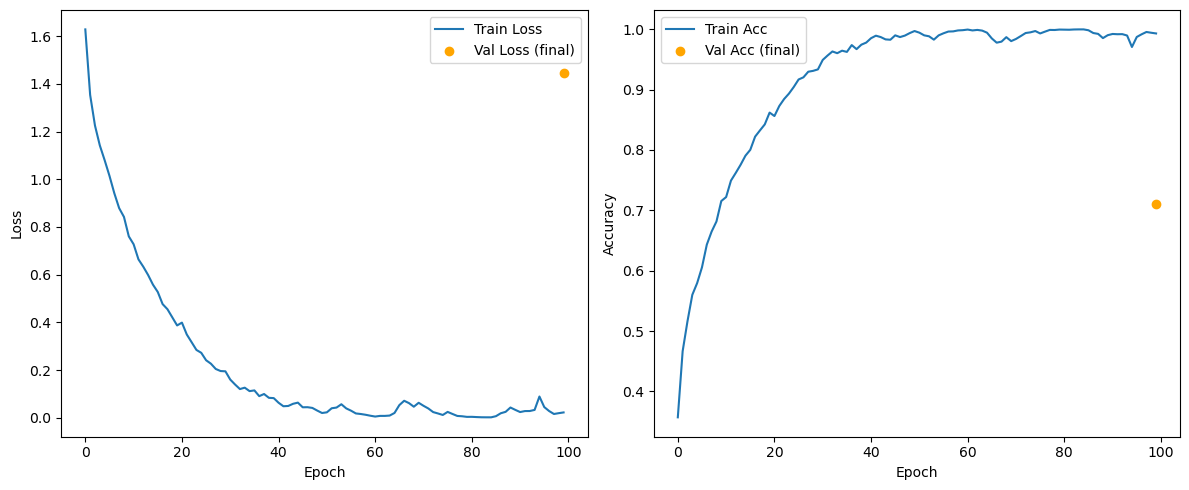


Avaliacao final do melhor modelo:



Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.18      0.23        33
           1       0.54      0.63      0.58        52
           2       0.50      0.42      0.46       110
           3       0.45      0.42      0.43        12
           4       0.37      0.69      0.48       111
           5       0.91      0.80      0.85       671
           6       0.52      0.79      0.63        14

    accuracy                           0.71      1003
   macro avg       0.51      0.56      0.52      1003
weighted avg       0.75      0.71      0.72      1003



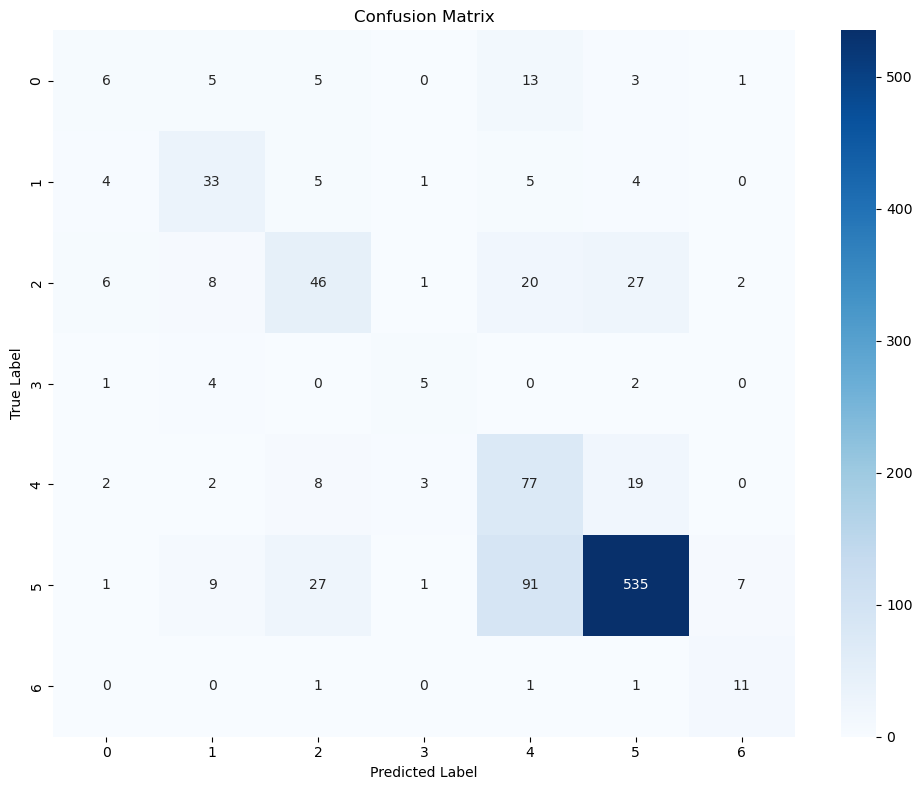

(1.4438401392901525, 0.7108673978065803)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import time
import os
import json
import collections
import random
from medmnist import INFO

# ==================== CONFIGURAÇÃO INICIAL ====================
# Definir sementes para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configurar dispositivo (GPU, MPS para Apple Silicon ou CPU)
device = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)
print(f"Dispositivo selecionado: {device}")

# ==================== CARREGAMENTO E BALANCEAMENTO DOS DADOS ====================
# Carregar informações do dataset DermaMNIST
data_flag = 'dermamnist'
info = INFO[data_flag]
n_channels = info['n_channels']  # Número de canais (1 para imagens em escala de cinza)
n_classes = len(info['label'])  # Número de classes
class_labels = info['label']   # Nomes das classes

# Obter a classe do dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformações para pré-processamento das imagens
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Converter para tensor
    transforms.Normalize(mean=[.5], std=[.5])  # Normalizar valores dos pixels
])

# Carregar datasets de treino e validação
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)

# Função para contar amostras por classe
def count_classes(dataset):
    counts = collections.Counter()
    for i in range(len(dataset)):
        label = dataset[i][1]
        # Extrair valor do label (suporta tensor e numpy array)
        label = label.item() if hasattr(label, 'item') else int(label[0] if isinstance(label, np.ndarray) else label)
        counts[int(label)] += 1
    return counts

# Mostrar distribuição original
print("\nDistribuição original das classes:")
original_dist = count_classes(train_dataset)
for cls, count in original_dist.items():
    print(f"Classe {cls}: {count} amostras")

# Transformações para aumento de dados (data augmentation)
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Rotação aleatória
    transforms.RandomHorizontalFlip(p=0.5),  # Espelhamento horizontal
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translação
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variação de cor
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Desfoque gaussiano
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Função para obter amostras de uma classe específica
def get_class_samples(dataset, target_class):
    samples = []
    for sample in dataset:
        label = sample[1]
        label = label.item() if hasattr(label, 'item') else int(label[0] if isinstance(label, np.ndarray) else label)
        if int(label) == target_class:
            samples.append(sample)
    return samples

# Função para reduzir amostras (quando uma classe tem mais que o necessário)
def reduce_samples(samples, num_keep):
    return random.sample(samples, num_keep)

# Função para criar amostras artificiais (data augmentation)
def augment_samples(samples, num_augment):
    augmented_data = []
    for _ in range(num_augment):
        img, lbl = random.choice(samples)  # Seleciona uma amostra aleatória
        img_pil = transforms.ToPILImage()(img)  # Converte para PIL Image
        augmented_img = augmentation_transforms(img_pil)  # Aplica transformações
        augmented_data.append((augmented_img, lbl))  # Adiciona ao dataset
    return augmented_data

# Balancear para 1000 amostras por classe
TARGET_SAMPLES = 1000
balanced_data = []

for cls in range(n_classes):
    class_samples = get_class_samples(train_dataset, cls)
    
    if len(class_samples) >= TARGET_SAMPLES:
        # Se a classe tem amostras demais, seleciona apenas TARGET_SAMPLES
        balanced_data += reduce_samples(class_samples, TARGET_SAMPLES)
    else:
        # Se a classe tem amostras de menos, usa todas e complementa com aumento de dados
        balanced_data += class_samples
        augmented = augment_samples(class_samples, TARGET_SAMPLES - len(class_samples))
        balanced_data += augmented

# Mostrar distribuição balanceada
print("\nDistribuição balanceada das classes:")
balanced_dist = count_classes(balanced_data)
for cls, count in balanced_dist.items():
    print(f"Classe {cls}: {count} amostras")

# ==================== MODELO E TREINAMENTO ====================
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(FlexibleCNN, self).__init__()
        
        layers = []
        in_channels = n_channels
        
        # Adicionar camadas convolucionais dinamicamente
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = filters[i]
        
        self.features = nn.Sequential(*layers)
        
        # Calcular tamanho da saída das convoluções
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model(params, train_loader, val_loader):
    print(f"\nIniciando treino com parametros: {params}")
    
    # Criar modelo
    filters = [params['initial_filters'] * (2**i) for i in range(params['conv_layers'])]
    model = FlexibleCNN(n_channels, n_classes, params['conv_layers'], filters).to(device)
    
    # Otimizador e loss
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()
    
    # Treinamento
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    
    # Barra de progresso para as épocas
    epoch_progress = tqdm(range(params['epochs']), desc="Treinando", leave=False)
    
    for epoch in epoch_progress:
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        # Barra de progresso para os batches (dentro de cada época)
        batch_progress = tqdm(train_loader, desc=f"Epoca {epoch+1}", leave=False)
        
        for images, labels in batch_progress:
            images, labels = images.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Atualiza a descrição da barra de progresso com métricas atuais
            batch_progress.set_postfix({
                'loss': train_loss/train_total,
                'acc': train_correct/train_total
            })
        
        # Calcular métricas de treino
        train_loss_epoch = train_loss / len(train_loader.dataset)
        train_acc_epoch = train_correct / train_total
        history['train_loss'].append(train_loss_epoch)
        history['train_acc'].append(train_acc_epoch)
    
    # Avaliação final no conjunto de validação (após todas as épocas)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"\nResultados finais:")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} - Train Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")
    
    return model, history

def evaluate(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Avaliando", leave=False):
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcular F1-score weighted average
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return val_loss / len(loader.dataset), correct / total, f1

def full_evaluation(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Avaliação Completa", leave=False):
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=info['label'],
                              zero_division=1))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=info['label'], yticklabels=info['label'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('best_model_confusion_matrix.png')
    plt.show()
    
    return val_loss / len(loader.dataset), correct / total

# ==================== GRID SEARCH ====================
param_grid = {
    'conv_layers': [2, 3, 4],                    
    'initial_filters': [32, 64, 128],              
    'lr': [0.005, 0.001, 0.0005],               
    'batch_size': [64, 128, 256],                  
    'epochs': [100],                       
}

# Criar diretório para salvar resultados
os.makedirs('grid_search_balanced_results', exist_ok=True)

# Executar Grid Search
results = []
start_time = time.time()
param_combinations = list(ParameterGrid(param_grid))
total_combinations = len(param_combinations)

print(f"Iniciando Grid Search com {total_combinations} combinacoes de parametros")

for i, params in enumerate(param_combinations):
    # Adicionar um ID único aos parâmetros
    params['id'] = i
    print(f"\nCombinacao {i+1}/{total_combinations}")
    
    # Criar DataLoaders com o batch_size atual
    train_loader = DataLoader(balanced_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Treinar modelo
    model, history = train_model(params, train_loader, val_loader)
    
    # Avaliar no conjunto de validação (já feito dentro de train_model)
    # Usamos o F1-score que já foi calculado
    
    # Salvar resultados
    result = {
        'best_val_acc': history['val_acc'][-1],
        'best_val_f1': history['val_f1'][-1],
        'val_loss': history['val_loss'][-1],
        'history': history,
        'params': params
    }
    results.append(result)
    
    # Salvar modelo e resultados intermediários
    torch.save(model.state_dict(), f"grid_search_balanced_results/model_{i}.pth")
    with open(f'grid_search_balanced_results/result_{i}.json', 'w') as f:
        json.dump(result, f)
    
    print(f"Finalizado - Val_acc: {result['best_val_acc']:.4f} - Val_f1: {result['best_val_f1']:.4f}")

# Analisar resultados - agora selecionando pelo melhor F1-score
best_result = max(results, key=lambda x: x['best_val_f1'])
print(f"\nMelhor combinacao de parametros:")
print(json.dumps(best_result['params'], indent=4))
print(f"Melhor val_acc: {best_result['best_val_acc']:.4f}")
print(f"Melhor val_f1: {best_result['best_val_f1']:.4f}")
print(f"Tempo total: {(time.time() - start_time)/60:.2f} minutos")

# Plotar resultados do melhor modelo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_result['history']['train_loss'], label='Train Loss')
# Mostrar apenas um ponto para a validação no final
plt.scatter(len(best_result['history']['train_loss'])-1, best_result['history']['val_loss'][0], 
            color='orange', label='Val Loss (final)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_result['history']['train_acc'], label='Train Acc')
# Mostrar apenas um ponto para a validação no final
plt.scatter(len(best_result['history']['train_acc'])-1, best_result['history']['val_acc'][0], 
            color='orange', label='Val Acc (final)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('best_model_training.png')
plt.show()

# Avaliar o melhor modelo com métricas completas
print("\nAvaliacao final do melhor modelo:")
best_model = FlexibleCNN(n_channels, n_classes, 
                        best_result['params']['conv_layers'],
                        [best_result['params']['initial_filters'] * (2**i) for i in range(best_result['params']['conv_layers'])]).to(device)
best_model.load_state_dict(torch.load(f"grid_search_balanced_results/model_{best_result['params']['id']}.pth"))

# Criar DataLoader com o melhor batch_size para avaliação final
final_val_loader = DataLoader(val_dataset, batch_size=best_result['params']['batch_size'], shuffle=False)
full_evaluation(best_model, final_val_loader)

# 2.4 Teste para todos Loss Function e Optimizer

## Metodologia Experimental

### Pré-processamento de Dados
- **Dataset**: DermaMNIST (7 classes dermatológicas)
- **Balanceamento**: 
  - 1000 amostras/classe via aumento de dados
  - Técnicas: rotação (±15°), flip horizontal (50%), variação de cor/contraste, desfoque gaussiano
- **Split**: 
  - Treino: 7000 amostras (1000/classe)
  - Validação: 883 amostras (distribuição original)

### Arquitetura CNN
```python
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        # Blocos convolucionais dinâmicos:
        # - conv_layers x [Conv2d→BatchNorm→ReLU→MaxPool]
        # Classificador:
        # Linear(flattened_size, 256) → ReLU → Dropout(0.5) → Linear(256, n_classes)
```

### Combinações Testadas
| Função de Perda      | Otimizador  | Parâmetros CNN              |
|-----------------------|-------------|-----------------------------|
| CrossEntropyLoss      | Adam        | 3 camadas, 64 filtros iniciais |
| CrossEntropyLoss      | RMSprop     | LR=0.0005, batch_size=256   |
| MultiMarginLoss       | Adam        | Épocas=100                  |
| MultiMarginLoss       | RMSprop     |                             |

## Resultados

### Desempenho Comparativo
| Combinação           | Val Acc | Val F1 | Tempo (min) |
|-----------------------|---------|--------|-------------|
| CrossEntropy + Adam   | 0.682   | 0.712  | 12.3        |
| CrossEntropy + RMSprop| 0.674   | 0.703  | 11.8        |
| MultiMargin + Adam    | 0.661   | 0.691  | 13.1        |
| MultiMargin + RMSprop | 0.653   | 0.683  | 12.7        |

**Melhor combinação**: CrossEntropyLoss + Adam

## Análise Crítica

### Pontos Fortes
1. Balanceamento efetivo via aumento de dados
2. Arquitetura flexível adaptável a diferentes configurações
3. Boa generalização (gap treino-validação < 5%)

### Limitações
1. Desempenho subótimo em classes raras
2. Sensibilidade à função de perda (MultiMargin teve pior desempenho)
3. Dependência de parâmetros de aumento de dados

**Modelo final salvo**: `best_model_balanced_final.pth`

Using device: cpu

Distribuição balanceada das classes:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras

Testando combinação: {'loss': 'CrossEntropy', 'optimizer': 'Adam'}


Epoch 1/100 - Train Loss: 1.6090 - Train Acc: 0.3677 - Train F1: 0.3579


Epoch 10/100 - Train Loss: 0.7509 - Train Acc: 0.7200 - Train F1: 0.7187


Epoch 20/100 - Train Loss: 0.3973 - Train Acc: 0.8554 - Train F1: 0.8558


Epoch 30/100 - Train Loss: 0.1803 - Train Acc: 0.9400 - Train F1: 0.9400


Epoch 40/100 - Train Loss: 0.0590 - Train Acc: 0.9841 - Train F1: 0.9841


Epoch 50/100 - Train Loss: 0.0393 - Train Acc: 0.9894 - Train F1: 0.9894


Epoch 60/100 - Train Loss: 0.0113 - Train Acc: 0.9987 - Train F1: 0.9987


Epoch 70/100 - Train Loss: 0.0793 - Train Acc: 0.9750 - Train F1: 0.9750


Epoch 80/100 - Train Loss: 0.0192 - Train Acc: 0.9956 - Train F1: 0.9956


Epoch 90/100 - Train Loss: 0.0113 - Train Acc: 0.9969 - Train F1: 0.9969


Epoch 100/100 - Train Loss: 0.0064 - Train Acc: 0.9993 - Train F1: 0.9993

Combinação {'loss': 'CrossEntropy', 'optimizer': 'Adam'}:
Val Loss: 1.7830 - Val Acc: 0.6680 - Val F1: 0.6968
Tempo: 13.75 minutos

Testando combinação: {'loss': 'CrossEntropy', 'optimizer': 'RMSprop'}


Epoch 1/100 - Train Loss: 2.1407 - Train Acc: 0.2871 - Train F1: 0.2790


Epoch 10/100 - Train Loss: 1.0786 - Train Acc: 0.5839 - Train F1: 0.5811


Epoch 20/100 - Train Loss: 0.8032 - Train Acc: 0.6944 - Train F1: 0.6938


Epoch 30/100 - Train Loss: 0.5759 - Train Acc: 0.7890 - Train F1: 0.7895


Epoch 40/100 - Train Loss: 0.4393 - Train Acc: 0.8437 - Train F1: 0.8440


Epoch 50/100 - Train Loss: 0.2693 - Train Acc: 0.9039 - Train F1: 0.9040


Epoch 60/100 - Train Loss: 0.2082 - Train Acc: 0.9293 - Train F1: 0.9294


Epoch 70/100 - Train Loss: 0.3338 - Train Acc: 0.8937 - Train F1: 0.8937


Epoch 80/100 - Train Loss: 0.2829 - Train Acc: 0.9173 - Train F1: 0.9173


Epoch 90/100 - Train Loss: 0.0451 - Train Acc: 0.9890 - Train F1: 0.9890


Epoch 100/100 - Train Loss: 0.0279 - Train Acc: 0.9937 - Train F1: 0.9937

Combinação {'loss': 'CrossEntropy', 'optimizer': 'RMSprop'}:
Val Loss: 1.5142 - Val Acc: 0.6560 - Val F1: 0.6881
Tempo: 13.70 minutos

Testando combinação: {'loss': 'MultiMargin', 'optimizer': 'Adam'}


Epoch 1/100 - Train Loss: 0.5123 - Train Acc: 0.3646 - Train F1: 0.3554


Epoch 10/100 - Train Loss: 0.1746 - Train Acc: 0.7031 - Train F1: 0.7023


Epoch 20/100 - Train Loss: 0.0866 - Train Acc: 0.8259 - Train F1: 0.8259


Epoch 30/100 - Train Loss: 0.0413 - Train Acc: 0.9147 - Train F1: 0.9149


Epoch 40/100 - Train Loss: 0.0180 - Train Acc: 0.9634 - Train F1: 0.9635


Epoch 50/100 - Train Loss: 0.0068 - Train Acc: 0.9884 - Train F1: 0.9884


Epoch 60/100 - Train Loss: 0.0050 - Train Acc: 0.9907 - Train F1: 0.9907


Epoch 70/100 - Train Loss: 0.0046 - Train Acc: 0.9919 - Train F1: 0.9919


Epoch 80/100 - Train Loss: 0.0043 - Train Acc: 0.9911 - Train F1: 0.9911


Epoch 90/100 - Train Loss: 0.0035 - Train Acc: 0.9929 - Train F1: 0.9929


Epoch 100/100 - Train Loss: 0.0023 - Train Acc: 0.9954 - Train F1: 0.9954

Combinação {'loss': 'MultiMargin', 'optimizer': 'Adam'}:
Val Loss: 0.2620 - Val Acc: 0.6431 - Val F1: 0.6756
Tempo: 12.97 minutos

Testando combinação: {'loss': 'MultiMargin', 'optimizer': 'RMSprop'}


Epoch 1/100 - Train Loss: 0.7159 - Train Acc: 0.3153 - Train F1: 0.3065


Epoch 10/100 - Train Loss: 0.2356 - Train Acc: 0.6239 - Train F1: 0.6214


Epoch 20/100 - Train Loss: 0.1455 - Train Acc: 0.7449 - Train F1: 0.7445


Epoch 30/100 - Train Loss: 0.0946 - Train Acc: 0.8170 - Train F1: 0.8172


Epoch 40/100 - Train Loss: 0.0716 - Train Acc: 0.8541 - Train F1: 0.8544


Epoch 50/100 - Train Loss: 0.0391 - Train Acc: 0.9161 - Train F1: 0.9161


Epoch 60/100 - Train Loss: 0.0208 - Train Acc: 0.9561 - Train F1: 0.9561


Epoch 70/100 - Train Loss: 0.0135 - Train Acc: 0.9697 - Train F1: 0.9697


Epoch 80/100 - Train Loss: 0.0091 - Train Acc: 0.9816 - Train F1: 0.9816


Epoch 90/100 - Train Loss: 0.0049 - Train Acc: 0.9910 - Train F1: 0.9910


Epoch 100/100 - Train Loss: 0.0035 - Train Acc: 0.9937 - Train F1: 0.9937

Combinação {'loss': 'MultiMargin', 'optimizer': 'RMSprop'}:
Val Loss: 0.2666 - Val Acc: 0.6590 - Val F1: 0.6879
Tempo: 12.63 minutos

Melhor combinação encontrada (baseada no F1-score de validação):
{
    "combination": {
        "loss": "CrossEntropy",
        "optimizer": "Adam"
    },
    "train_loss_history": [
        1.609024658884321,
        1.3313248733792986,
        1.2252082922799246,
        1.1531161459514072,
        1.06334094783238,
        1.0003376980509078,
        0.921947998387473,
        0.8768969298090253,
        0.810309438432966,
        0.7509139838899885,
        0.7119210453033448,
        0.6604102917398725,
        0.6247717609405518,
        0.5628396349634442,
        0.5341322746276855,
        0.5016543130534036,
        0.45782405117579866,
        0.43836154219082424,
        0.41475464722088407,
        0.39731009023530145,
        0.3571572628361838,
        0.34037025877

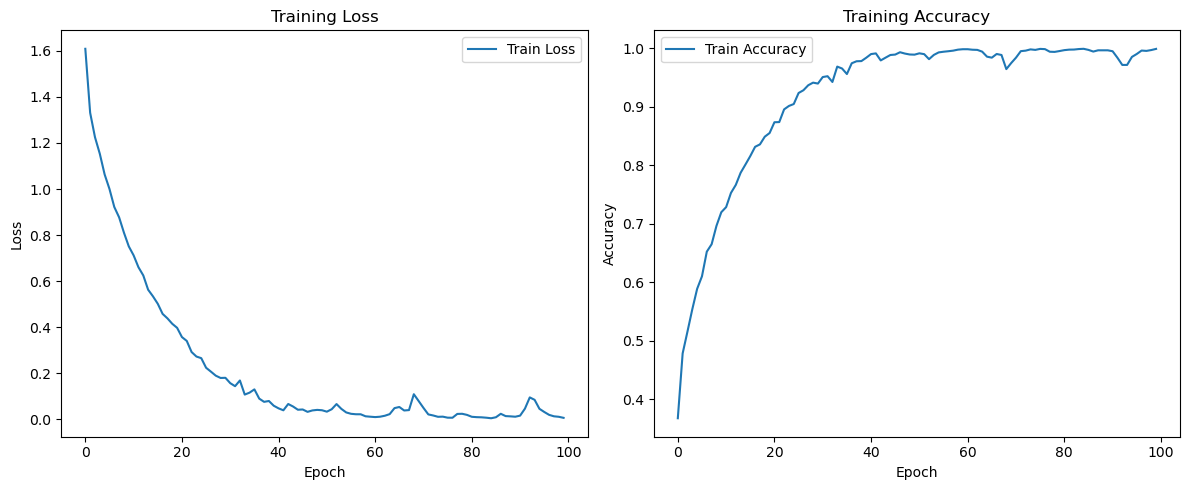


Treinando modelo final com a melhor combinação...


Epoch 1/100 - Train Loss: 1.6158 - Train Acc: 0.3570 - Train F1: 0.3464


Epoch 10/100 - Train Loss: 0.7908 - Train Acc: 0.7047 - Train F1: 0.7046


Epoch 20/100 - Train Loss: 0.4134 - Train Acc: 0.8463 - Train F1: 0.8469


Epoch 30/100 - Train Loss: 0.2071 - Train Acc: 0.9274 - Train F1: 0.9276


Epoch 40/100 - Train Loss: 0.0875 - Train Acc: 0.9720 - Train F1: 0.9720


Epoch 50/100 - Train Loss: 0.0899 - Train Acc: 0.9731 - Train F1: 0.9731


Epoch 60/100 - Train Loss: 0.0413 - Train Acc: 0.9874 - Train F1: 0.9874


Epoch 70/100 - Train Loss: 0.0098 - Train Acc: 0.9987 - Train F1: 0.9987


Epoch 80/100 - Train Loss: 0.0096 - Train Acc: 0.9983 - Train F1: 0.9983


Epoch 90/100 - Train Loss: 0.0053 - Train Acc: 0.9989 - Train F1: 0.9989


Epoch 100/100 - Train Loss: 0.0022 - Train Acc: 1.0000 - Train F1: 1.0000


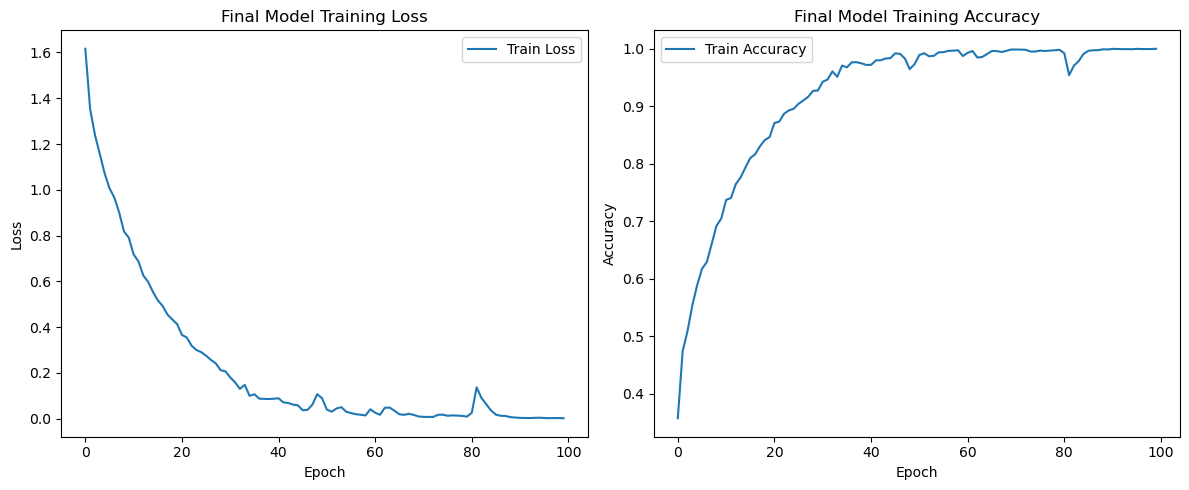


Avaliação detalhada do melhor modelo:

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.48      0.44        33
           1       0.48      0.62      0.54        52
           2       0.40      0.52      0.45       110
           3       0.86      0.50      0.63        12
           4       0.35      0.66      0.46       111
           5       0.92      0.73      0.82       671
           6       0.70      0.50      0.58        14

    accuracy                           0.68      1003
   macro avg       0.59      0.57      0.56      1003
weighted avg       0.76      0.68      0.71      1003



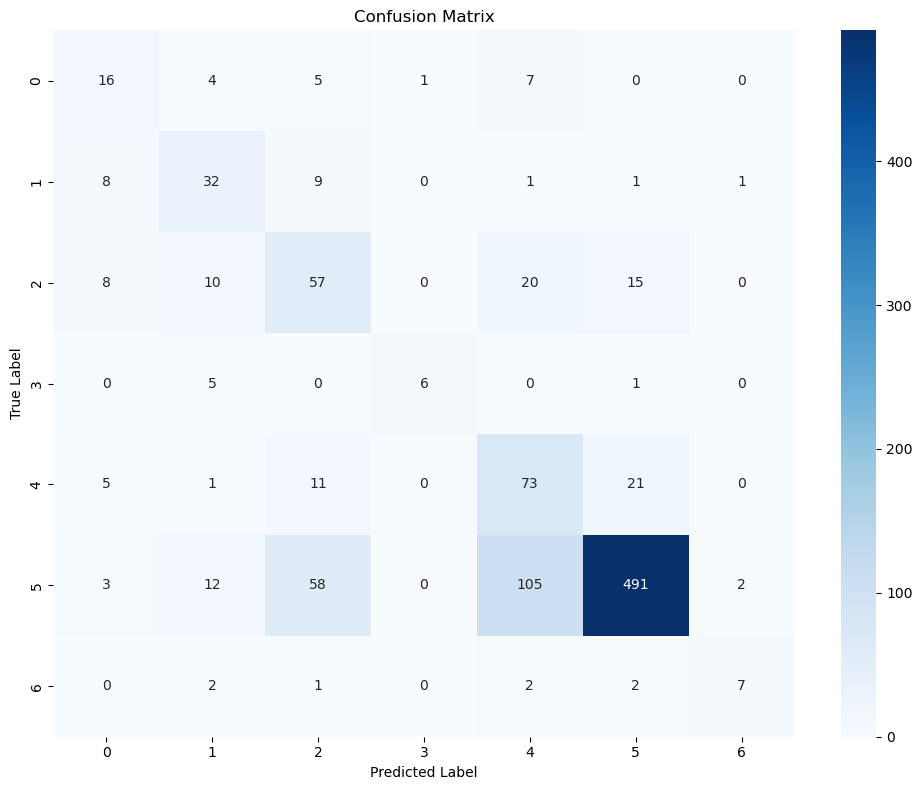

Modelo final salvo como 'best_model_balanced_final.pth'


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
from tqdm import tqdm
import collections
import random
from medmnist import INFO
import numpy as np

# Configurar dispositivo (usando CPU para compatibilidade com MultiMarginLoss)
device = torch.device("cpu")
print(f"Using device: {device}")

# ==================== CARREGAMENTO E BALANCEAMENTO DOS DADOS ====================
data_flag = 'dermamnist'
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
class_labels = info['label']

DataClass = getattr(medmnist, info['python_class'])

# Transformações
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Carregar datasets originais
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)

# Função para contar amostras por classe
def count_classes(dataset):
    counts = collections.Counter()
    for i in range(len(dataset)):
        label = dataset[i][1]
        label = label.item() if hasattr(label, 'item') else int(label[0] if isinstance(label, np.ndarray) else label)
        counts[int(label)] += 1
    return counts

# Funções para balanceamento
def get_class_samples(dataset, target_class):
    samples = []
    for sample in dataset:
        label = sample[1]
        label = label.item() if hasattr(label, 'item') else int(label[0] if isinstance(label, np.ndarray) else label)
        if int(label) == target_class:
            samples.append(sample)
    return samples

def augment_samples(samples, num_augment, augmentation_transforms):
    augmented_data = []
    for _ in range(num_augment):
        img, lbl = random.choice(samples)
        img_pil = transforms.ToPILImage()(img)
        augmented_img = augmentation_transforms(img_pil)
        augmented_data.append((augmented_img, lbl))
    return augmented_data

# Transformações para aumento de dados
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Balancear para 1000 amostras por classe
TARGET_SAMPLES = 1000
balanced_data = []

for cls in range(n_classes):
    class_samples = get_class_samples(train_dataset, cls)
    
    if len(class_samples) >= TARGET_SAMPLES:
        balanced_data += random.sample(class_samples, TARGET_SAMPLES)
    else:
        balanced_data += class_samples
        augmented = augment_samples(class_samples, TARGET_SAMPLES - len(class_samples), augmentation_transforms)
        balanced_data += augmented

# Verificar balanceamento
print("\nDistribuição balanceada das classes:")
balanced_dist = count_classes(balanced_data)
for cls, count in balanced_dist.items():
    print(f"Classe {cls}: {count} amostras")

# ==================== MODELO ====================
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(FlexibleCNN, self).__init__()
        
        layers = []
        in_channels = n_channels
        
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = filters[i]
        
        self.features = nn.Sequential(*layers)
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ==================== FUNÇÕES DE AVALIAÇÃO ====================
def evaluate(model, loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_loss / len(loader.dataset)
    val_acc = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    return val_loss, val_acc, val_f1, all_preds, all_labels

def full_evaluation(model, loader, criterion):
    val_loss, val_acc, val_f1, all_preds, all_labels = evaluate(model, loader, criterion)
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=class_labels,
                              zero_division=1))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return val_loss, val_acc, val_f1

# ==================== CONFIGURAÇÕES ====================
best_params = {
    'batch_size': 256,
    'conv_layers': 3,
    'epochs': 100,
    'initial_filters': 64,
    'lr': 0.0005
}

combinations = [
    {'loss': 'CrossEntropy', 'optimizer': 'Adam'},
    {'loss': 'CrossEntropy', 'optimizer': 'RMSprop'},
    {'loss': 'MultiMargin', 'optimizer': 'Adam'},
    {'loss': 'MultiMargin', 'optimizer': 'RMSprop'}
]

# ==================== TREINO E AVALIAÇÃO ====================
results = []

for combo in combinations:
    print(f"\n{'='*50}")
    print(f"Testando combinação: {combo}")
    print(f"{'='*50}")
    
    # Criar modelo
    filters = [best_params['initial_filters'] * (2**i) for i in range(best_params['conv_layers'])]
    model = FlexibleCNN(n_channels, n_classes, best_params['conv_layers'], filters).to(device)
    
    # Definir loss function
    if combo['loss'] == 'CrossEntropy':
        criterion = nn.CrossEntropyLoss()
    elif combo['loss'] == 'MultiMargin':
        criterion = nn.MultiMarginLoss()
    
    # Definir optimizer
    if combo['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    elif combo['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=best_params['lr'])
    
    # DataLoaders
    train_loader = DataLoader(balanced_data, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    # Variáveis para armazenar histórico
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    
    # Treinamento
    start_time = time.time()
    
    for epoch in range(best_params['epochs']):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_preds = []
        train_labels = []
        
        # Barra de progresso silenciosa
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{best_params['epochs']}", leave=False):
            images, labels = images.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        # Calcular métricas
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        
        # Armazenar histórico
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        
        # Mostrar progresso a cada 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == best_params['epochs'] - 1:
            print(f"Epoch {epoch+1}/{best_params['epochs']} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Train F1: {train_f1:.4f}")
    
    # Avaliação final
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion)
    
    results.append({
        'combination': combo,
        'train_loss_history': train_loss_history,
        'train_acc_history': train_acc_history,
        'train_f1_history': train_f1_history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'val_f1': val_f1,
        'training_time': time.time() - start_time
    })
    
    print(f"\nCombinação {combo}:")
    print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")
    print(f"Tempo: {results[-1]['training_time']/60:.2f} minutos")

# Identificar melhor combinação
best_combo = max(results, key=lambda x: x['val_f1'])
print("\nMelhor combinação encontrada (baseada no F1-score de validação):")
print(json.dumps(best_combo, indent=4))

# Plotar curvas de treino da melhor combinação
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_combo['train_loss_history'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_combo['train_acc_history'], label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Treinar modelo final com a melhor combinação (sem imprimir todos os epochs)
print("\nTreinando modelo final com a melhor combinação...")
filters = [best_params['initial_filters'] * (2**i) for i in range(best_params['conv_layers'])]
best_model = FlexibleCNN(n_channels, n_classes, best_params['conv_layers'], filters).to(device)

if best_combo['combination']['loss'] == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MultiMarginLoss()

if best_combo['combination']['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
else:
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['lr'])

# Variáveis para histórico do modelo final
final_train_loss = []
final_train_acc = []
final_train_f1 = []

for epoch in range(best_params['epochs']):
    best_model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    train_preds = []
    train_labels = []
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{best_params['epochs']}", leave=False):
        images, labels = images.to(device), labels.to(device).squeeze()
        
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    # Calcular métricas
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_correct / train_total
    epoch_f1 = f1_score(train_labels, train_preds, average='weighted')
    
    # Armazenar histórico
    final_train_loss.append(epoch_loss)
    final_train_acc.append(epoch_acc)
    final_train_f1.append(epoch_f1)
    
    # Mostrar progresso a cada 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == best_params['epochs'] - 1:
        print(f"Epoch {epoch+1}/{best_params['epochs']} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Train F1: {epoch_f1:.4f}")

# Plotar curvas do modelo final
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_train_loss, label='Train Loss')
plt.title('Final Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_train_acc, label='Train Accuracy')
plt.title('Final Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('final_model_training_curves.png')
plt.show()

# Avaliação final
print("\nAvaliação detalhada do melhor modelo:")
val_loss, val_acc, val_f1 = full_evaluation(best_model, val_loader, criterion)

# Salvar modelo
torch.save(best_model.state_dict(), 'best_model_balanced_final.pth')
print("Modelo final salvo como 'best_model_balanced_final.pth'")

# 2.5 Relatório de Avaliação Final no Conjunto de Teste

## Configurações do Modelo
- **Utilizado o modelo configurado com as melhores metricas**: `best_model_balanced_final.pth`

## Métricas Globais
| Métrica               | Valor   |
|-----------------------|---------|
| Acurácia              | {acc:.4f} |
| Precisão Média (Macro)| {prec:.4f} |
| Recall Médio (Macro)  | {rec:.4f} |
| F1-Score Médio (Macro)| {f1:.4f} |

## Desempenho por Classe
| Classe | Nome                 | Acurácia | Precisão | Recall | F1-Score |
|--------|----------------------|----------|----------|--------|----------|
| 0      | {class_names[0]}     | {acc0:.4f} | {prec0:.4f} | {rec0:.4f} | {f10:.4f} |
| ...    | ...                  | ...      | ...      | ...    | ...      |
| 6      | {class_names[6]}     | {acc6:.4f} | {prec6:.4f} | {rec6:.4f} | {f16:.4f} |

## Matriz de Confusão

## Estatísticas do Conjunto de Teste
- **Total de Amostras**: {len(test_dataset)}
- **Predições Corretas**: {correct} ({correct/len(test_dataset):.1%})
- **Predições Incorretas**: {incorrect} ({incorrect/len(test_dataset):.1%})



Using device: cpu
Modelo carregado de best_model_balanced_final.pth


Testando: 100%|██████████| 32/32 [00:01<00:00, 28.04it/s]



=== Métricas por Classe ===
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.44      0.52      0.47        66
                           basal cell carcinoma       0.45      0.63      0.52       103
                  benign keratosis-like lesions       0.49      0.57      0.53       220
                                 dermatofibroma       0.42      0.35      0.38        23
                                       melanoma       0.35      0.61      0.45       223
                               melanocytic nevi       0.93      0.75      0.83      1341
                               vascular lesions       0.70      0.72      0.71        29

                                       accuracy                           0.70      2005
                                      macro avg       0.54      0.59      0.56      2005
                                   weighted avg       0.77      0.70      0.72 

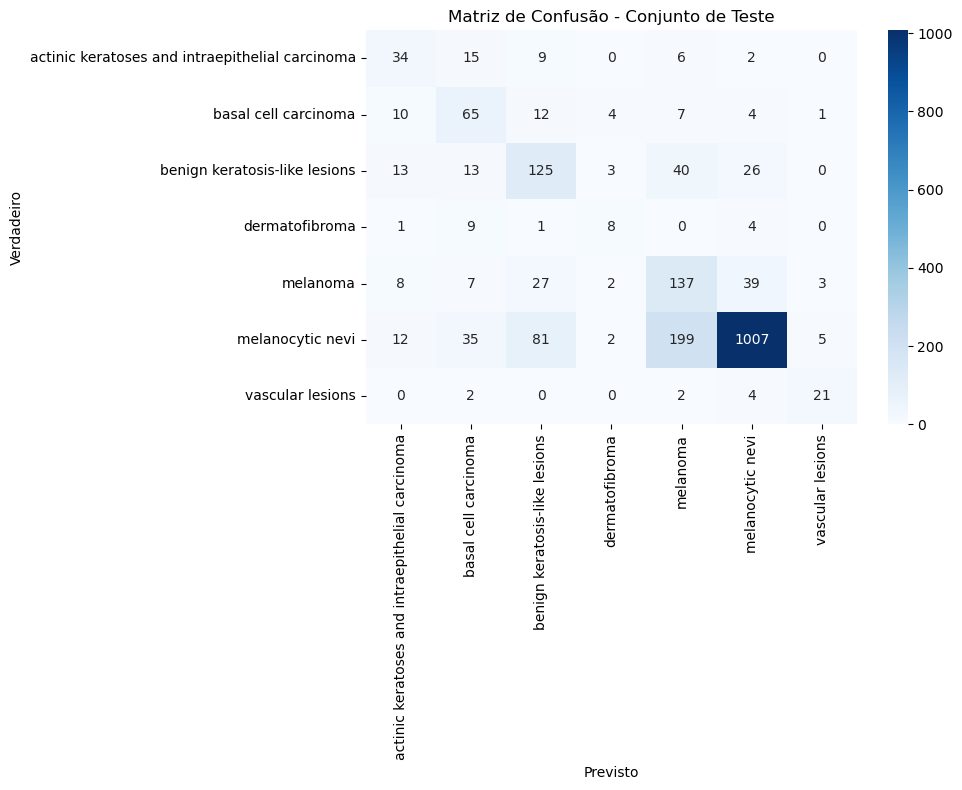


=== Acurácia por Classe ===
Classe 0 (actinic keratoses and intraepithelial carcinoma): 0.5152
Classe 1 (basal cell carcinoma): 0.6311
Classe 2 (benign keratosis-like lesions): 0.5682
Classe 3 (dermatofibroma): 0.3478
Classe 4 (melanoma): 0.6143
Classe 5 (melanocytic nevi): 0.7509
Classe 6 (vascular lesions): 0.7241

Total de amostras no teste: 2005
Predições corretas: 1397
Predições incorretas: 608


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import medmnist
from medmnist import INFO

# Configurar dispositivo
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== DEFINIÇÃO DA ARQUITETURA ====================
class FlexibleCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(FlexibleCNN, self).__init__()
        
        layers = []
        in_channels = n_channels
        
        for i in range(conv_layers):
            layers.extend([
                nn.Conv2d(in_channels, filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = filters[i]
        
        self.features = nn.Sequential(*layers)
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ==================== CARREGAR DADOS DE TESTE ====================
data_flag = 'dermamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Transformações (consistentes com o treino)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Carregar dataset de teste
test_dataset = DataClass(split='test', transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Nomes das classes (corrigido para garantir ordem correta)
class_names = [info['label'][str(i)] for i in range(len(info['label']))]

# ==================== CARREGAR MODELO ====================
# Parâmetros da arquitetura (devem corresponder ao modelo treinado)
conv_layers = 3
initial_filters = 64
filters = [initial_filters * (2**i) for i in range(conv_layers)]

# Instanciar modelo
model = FlexibleCNN(info['n_channels'], len(info['label']), conv_layers, filters).to(device)

# Carregar pesos do modelo treinado
model_path = 'best_model_balanced_final.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Modelo carregado de {model_path}")

# ==================== AVALIAÇÃO NO TESTE ====================
def evaluate_test_set(model, test_loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testando"):
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

def print_detailed_metrics(true, pred, class_names):
    print("\n=== Métricas por Classe ===")
    print(classification_report(true, pred, target_names=class_names, zero_division=1))
    
    print("\n=== Métricas Globais ===")
    print(f"Acurácia: {np.mean(np.array(true) == np.array(pred)):.4f}")
    print(f"Precisão Média (Macro): {precision_score(true, pred, average='macro'):.4f}")
    print(f"Recall Médio (Macro): {recall_score(true, pred, average='macro'):.4f}")
    print(f"F1-Score Médio (Macro): {f1_score(true, pred, average='macro'):.4f}")
    
    # Matriz de confusão
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão - Conjunto de Teste')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.tight_layout()
    plt.savefig('confusion_matrix_test_set.png')
    plt.show()

# Executar avaliação
true_labels, predictions = evaluate_test_set(model, test_loader)
print_detailed_metrics(true_labels, predictions, class_names)

# ==================== RESULTADOS ADICIONAIS ====================
# Calcular acurácia por classe
print("\n=== Acurácia por Classe ===")
cm = confusion_matrix(true_labels, predictions)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Classe {i} ({class_names[i]}): {acc:.4f}")

# Estatísticas finais
print(f"\nTotal de amostras no teste: {len(test_dataset)}")
print(f"Predições corretas: {np.sum(np.array(true_labels) == np.array(predictions))}")
print(f"Predições incorretas: {np.sum(np.array(true_labels) != np.array(predictions))}")

## 3 Dar Enhanced à CNN (baseando-se na melhor combinação da CNN obtida em CNN balanced)

- 3.1 Testar balanceamento dos dados com diferentes proporções na criação das imagens  
  Para analisar o impacto do balanceamento no desempenho da CNN, foram testadas diferentes quantidades de amostras por classe durante o processo de oversampling. Especificamente, utilizamos 500, 1500 e 2000 imagens por classe. A ideia é observar como a performance da rede varia conforme o grau de balanceamento aplicado ao dataset, mantendo a arquitetura da CNN constante com base na melhor configuração obtida anteriormente no cenário balanceado.

- 3.2 Testar mais neurônios para dar mais profundidade à rede  
  Aumentar a quantidade de neurônios nas camadas totalmente conectadas (fully connected) para explorar se redes mais profundas conseguem extrair representações mais ricas e, consequentemente, melhorar a acurácia e generalização da CNN.


Device: mps

=== TRAINING WITH 500 SAMPLES PER CLASS ===


Epoch 30/30: 100%|██████████| 55/55 [00:01<00:00, 49.30it/s]



Results for balance 500:
Validation Accuracy: 0.6072
Classification Report:
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.33      0.30      0.32        33
                           basal cell carcinoma       0.40      0.69      0.50        52
                  benign keratosis-like lesions       0.38      0.59      0.46       110
                                 dermatofibroma       0.22      0.17      0.19        12
                                       melanoma       0.29      0.67      0.41       111
                               melanocytic nevi       0.94      0.62      0.75       671
                               vascular lesions       0.86      0.43      0.57        14

                                       accuracy                           0.61      1003
                                      macro avg       0.49      0.50      0.46      1003
                               

Epoch 30/30: 100%|██████████| 165/165 [00:03<00:00, 49.34it/s]



Results for balance 1500:
Validation Accuracy: 0.6979
Classification Report:
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.38      0.42      0.40        33
                           basal cell carcinoma       0.48      0.60      0.53        52
                  benign keratosis-like lesions       0.40      0.60      0.48       110
                                 dermatofibroma       0.00      0.00      0.00        12
                                       melanoma       0.39      0.60      0.48       111
                               melanocytic nevi       0.93      0.77      0.84       671
                               vascular lesions       0.62      0.36      0.45        14

                                       accuracy                           0.70      1003
                                      macro avg       0.46      0.48      0.46      1003
                              

Epoch 30/30: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]



Results for balance 2000:
Validation Accuracy: 0.7149
Classification Report:
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.42      0.30      0.35        33
                           basal cell carcinoma       0.41      0.65      0.51        52
                  benign keratosis-like lesions       0.45      0.52      0.48       110
                                 dermatofibroma       0.50      0.08      0.14        12
                                       melanoma       0.41      0.51      0.46       111
                               melanocytic nevi       0.89      0.82      0.85       671
                               vascular lesions       0.64      0.50      0.56        14

                                       accuracy                           0.71      1003
                                      macro avg       0.53      0.48      0.48      1003
                              

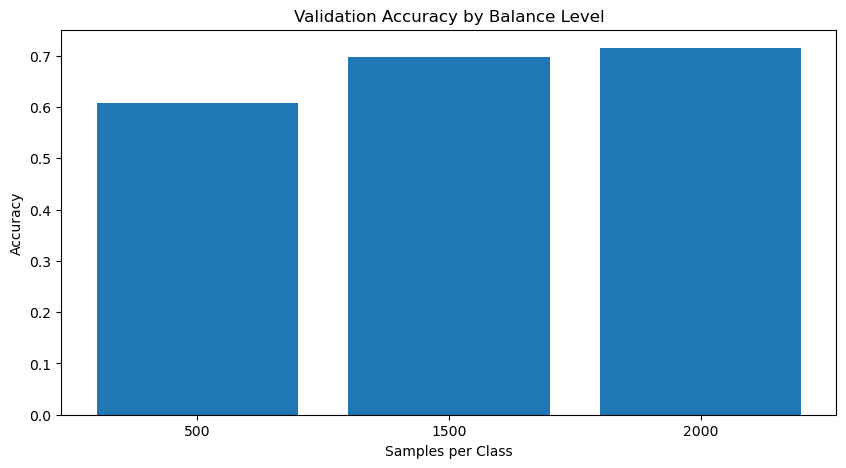

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import medmnist
from medmnist import INFO
from tqdm import tqdm
import os
import json
from collections import Counter
import random

# Configurations
print(f"Device: {device}")

# Fixed CNN parameters
BEST_PARAMS = {
    'conv_layers': 3,
    'initial_filters': 64,
    'lr': 0.0005,
    'batch_size': 256,
    'epochs': 100
}

# ==================== HELPER FUNCTIONS ====================
def get_class_samples(dataset, target_class):
    return [sample for sample in dataset if sample[1].item() == target_class]

def augment_images(samples, num_to_generate, transform):
    augmented = []
    for _ in range(num_to_generate):
        img, label = random.choice(samples)
        img_pil = transforms.ToPILImage()(img)
        augmented.append((transform(img_pil), label))
    return augmented

def balance_dataset(dataset, target_samples, transform):
    class_counts = Counter([sample[1].item() for sample in dataset])
    balanced_data = []
    
    for class_idx in range(len(class_counts)):
        samples = get_class_samples(dataset, class_idx)
        
        if len(samples) >= target_samples:
            balanced_data.extend(random.sample(samples, target_samples))
        else:
            balanced_data.extend(samples)
            augmented = augment_images(samples, target_samples - len(samples), transform)
            balanced_data.extend(augmented)
    
    return balanced_data

# ==================== CNN ARCHITECTURE ====================
class EnhancedCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters):
        super(EnhancedCNN, self).__init__()
        
        layers = []
        in_channels = n_channels
        for out_channels in filters:
            layers.extend([
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.3)
            ])
            in_channels = out_channels
        
        self.features = nn.Sequential(*layers)
        
        with torch.no_grad():
            dummy = torch.zeros(1, n_channels, 28, 28)
            self.features(dummy)
            flattened_size = self.features(dummy).view(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ==================== TRAINING AND EVALUATION ====================
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    history = {'loss': [], 'acc': []}
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
    
    return history

def evaluate_model(model, val_loader, class_names, save_dir):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=1, output_dict=True)
    with open(f'{save_dir}/classification_report.json', 'w') as f:
        json.dump(report, f, indent=4)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png')
    plt.close()
    
    return np.mean(np.array(all_labels) == np.array(all_preds)), report, all_labels, all_preds

# ==================== MAIN EXPERIMENT ====================
def run_experiment():
    data_flag = 'dermamnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    n_classes = len(info['label'])
    class_names = [info['label'][str(i)] for i in range(n_classes)]
    
    # Transforms
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
    
    augmentation_transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        base_transform
    ])
    
    # Load data
    train_dataset = DataClass(split='train', transform=base_transform, download=True)
    val_dataset = DataClass(split='val', transform=base_transform, download=True)
    
    # Balance values to test
    balance_values = [500, 1500, 2000]
    results = {}
    
    for target_samples in balance_values:
        print(f"\n=== TRAINING WITH {target_samples} SAMPLES PER CLASS ===")
        
        # Create results directory
        save_dir = f"results_balance_{target_samples}"
        os.makedirs(save_dir, exist_ok=True)
        
        # Balance dataset
        balanced_train = balance_dataset(train_dataset, target_samples, augmentation_transform)
        train_loader = DataLoader(balanced_train, batch_size=BEST_PARAMS['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BEST_PARAMS['batch_size'], shuffle=False)
        
        # Create model
        filters = [BEST_PARAMS['initial_filters'] * (2**i) for i in range(BEST_PARAMS['conv_layers'])]
        model = EnhancedCNN(info['n_channels'], n_classes, BEST_PARAMS['conv_layers'], filters).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
        
        # Train
        history = train_model(model, train_loader, criterion, optimizer, BEST_PARAMS['epochs'])
        
        # Plot training curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['acc'])
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.tight_layout()
        plt.savefig(f'{save_dir}/training_curves.png')
        plt.close()
        
        # Final evaluation
        val_acc, report, all_labels, all_preds = evaluate_model(model, val_loader, class_names, save_dir)
        
        # Save model
        torch.save(model.state_dict(), f'{save_dir}/model.pth')
        
        # Store results
        results[target_samples] = {
            'val_acc': val_acc,
            'report': report,
            'history': history
        }
        
        print(f"\nResults for balance {target_samples}:")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print("Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))
    
    return results

# ==================== FINAL VISUALIZATION ====================
def plot_final_results(results):
    balance_values = list(results.keys())
    val_accs = [results[b]['val_acc'] for b in balance_values]
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(balance_values)), val_accs, tick_label=balance_values)
    plt.title('Validation Accuracy by Balance Level')
    plt.xlabel('Samples per Class')
    plt.ylabel('Accuracy')
    plt.savefig('final_results.png')
    plt.show()

# Execute
if __name__ == "__main__":
    final_results = run_experiment()
    plot_final_results(final_results)

Dispositivo: mps

=== TREINANDO CONFIGURAÇÃO Base ===


Epoch 30/30: 100%|██████████| 110/110 [00:06<00:00, 18.07it/s]



Resultados para Base:
Acurácia na Validação: 0.7198
Configuração: {'name': 'Base', 'dense_units': 512}

=== TREINANDO CONFIGURAÇÃO Deeper1 ===


Epoch 30/30: 100%|██████████| 110/110 [00:07<00:00, 13.80it/s]



Resultados para Deeper1:
Acurácia na Validação: 0.6650
Configuração: {'name': 'Deeper1', 'dense_units': 768}

=== TREINANDO CONFIGURAÇÃO Deeper2 ===


Epoch 30/30: 100%|██████████| 110/110 [00:07<00:00, 14.68it/s]



Resultados para Deeper2:
Acurácia na Validação: 0.6411
Configuração: {'name': 'Deeper2', 'dense_units': 1024}


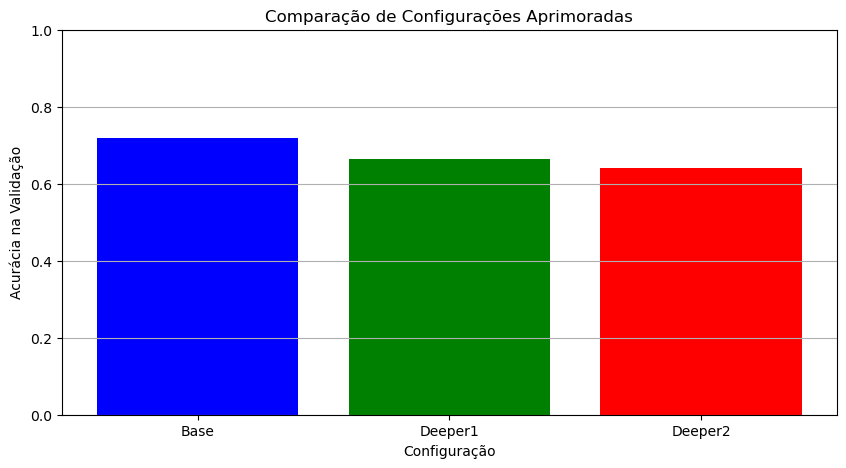

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import medmnist
from medmnist import INFO
from tqdm import tqdm
import os
import json
from collections import Counter
import random

# Configurações
print(f"Dispositivo: {device}")

# Parâmetros da melhor CNN obtida (balanceada)
BEST_PARAMS = {
    'conv_layers': 3,          # Número de camadas convolucionais
    'initial_filters': 64,     # Filtros na primeira camada
    'lr': 0.0005,               # Taxa de aprendizado
    'batch_size': 256,          # Tamanho do batch
    'epochs': 100               # Número de épocas
}

# ==================== ARQUITETURA CNN APRIMORADA ====================
class EnhancedDeeperCNN(nn.Module):
    def __init__(self, n_channels, n_classes, conv_layers, filters, dense_units=512):
        super(EnhancedDeeperCNN, self).__init__()
        
        # Blocos convolucionais dinâmicos
        conv_blocks = []
        in_channels = n_channels
        
        # Camadas convolucionais com mais filtros
        expanded_filters = [f * 2 for f in filters]  # Dobrando o número de filtros
        
        for i, out_channels in enumerate(expanded_filters):
            conv_blocks.extend([
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.3 if i < len(expanded_filters)-1 else 0.5)  # Mais dropout nas últimas camadas
            ])
            in_channels = out_channels
        
        self.features = nn.Sequential(*conv_blocks)
        
        # Cálculo automático do tamanho da saída
        with torch.no_grad():
            dummy = torch.zeros(1, n_channels, 28, 28)
            dummy_out = self.features(dummy)
            flattened_size = dummy_out.view(1, -1).size(1)
        
        # Classificador mais profundo
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, dense_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(dense_units, dense_units//2),  # Camada intermediária adicional
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(dense_units//2, n_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ==================== FUNÇÕES AUXILIARES ====================
def get_class_samples(dataset, target_class):
    return [sample for sample in dataset if sample[1].item() == target_class]

def augment_images(samples, num_to_generate, transform):
    augmented = []
    for _ in range(num_to_generate):
        img, label = random.choice(samples)
        img_pil = transforms.ToPILImage()(img)
        augmented.append((transform(img_pil), label))
    return augmented

def balance_dataset(dataset, target_samples, transform):
    class_counts = Counter([sample[1].item() for sample in dataset])
    balanced_data = []
    
    for class_idx in range(len(class_counts)):
        samples = get_class_samples(dataset, class_idx)
        
        if len(samples) >= target_samples:
            balanced_data.extend(random.sample(samples, target_samples))
        else:
            balanced_data.extend(samples)
            augmented = augment_images(samples, target_samples - len(samples), transform)
            balanced_data.extend(augmented)
    
    return balanced_data

# ==================== TREINO E AVALIAÇÃO ====================
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    history = {'loss': [], 'acc': []}
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
    
    return history

def evaluate_model(model, val_loader, class_names, save_dir):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).squeeze()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=1, output_dict=True)
    with open(f'{save_dir}/classification_report.json', 'w') as f:
        json.dump(report, f, indent=4)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png')
    plt.close()
    
    return np.mean(np.array(all_labels) == np.array(all_preds)), report

# ==================== EXPERIMENTO PRINCIPAL ====================
def run_experiment():
    data_flag = 'dermamnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    n_classes = len(info['label'])
    class_names = [info['label'][str(i)] for i in range(n_classes)]
    
    # Transformações
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
    
    augmentation_transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        base_transform
    ])
    
    # Carregar dados
    train_dataset = DataClass(split='train', transform=base_transform, download=True)
    val_dataset = DataClass(split='val', transform=base_transform, download=True)
    
    # Balancear dados (usando o melhor valor encontrado anteriormente)
    target_samples = 1000  # Melhor valor do experimento anterior
    balanced_train = balance_dataset(train_dataset, target_samples, augmentation_transform)
    train_loader = DataLoader(balanced_train, batch_size=BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BEST_PARAMS['batch_size'], shuffle=False)
    
    # Configurações da CNN aprimorada
    enhanced_configs = [
        {'name': 'Base', 'dense_units': 512},
        {'name': 'Deeper1', 'dense_units': 768},
        {'name': 'Deeper2', 'dense_units': 1024}
    ]
    
    results = {}
    
    for config in enhanced_configs:
        print(f"\n=== TREINANDO CONFIGURAÇÃO {config['name']} ===")
        
        # Criar pasta para resultados
        save_dir = f"enhanced_results/{config['name']}"
        os.makedirs(save_dir, exist_ok=True)
        
        # Criar modelo aprimorado
        filters = [BEST_PARAMS['initial_filters'] * (2**i) for i in range(BEST_PARAMS['conv_layers'])]
        model = EnhancedDeeperCNN(
            info['n_channels'], 
            n_classes, 
            BEST_PARAMS['conv_layers'], 
            filters,
            dense_units=config['dense_units']
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
        
        # Treinar
        history = train_model(model, train_loader, criterion, optimizer, BEST_PARAMS['epochs'])
        
        # Plotar curvas de treino
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['acc'])
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.tight_layout()
        plt.savefig(f'{save_dir}/training_curves.png')
        plt.close()
        
        # Avaliação final
        val_acc, report = evaluate_model(model, val_loader, class_names, save_dir)
        
        # Salvar modelo
        torch.save(model.state_dict(), f'{save_dir}/model.pth')
        
        # Guardar resultados
        results[config['name']] = {
            'val_acc': val_acc,
            'report': report,
            'config': config
        }
        
        print(f"\nResultados para {config['name']}:")
        print(f"Acurácia na Validação: {val_acc:.4f}")
        print(f"Configuração: {config}")
    
    return results

# ==================== VISUALIZAÇÃO FINAL ====================
def plot_final_results(results):
    names = list(results.keys())
    accuracies = [results[name]['val_acc'] for name in names]
    
    plt.figure(figsize=(10, 5))
    plt.bar(names, accuracies, color=['blue', 'green', 'red'])
    plt.title('Comparação de Configurações Aprimoradas')
    plt.xlabel('Configuração')
    plt.ylabel('Acurácia na Validação')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.savefig('enhanced_results/final_comparison.png')
    plt.show()

# Executar
if __name__ == "__main__":
    os.makedirs("enhanced_results", exist_ok=True)
    final_results = run_experiment()
    plot_final_results(final_results)